### WHOLE DAMN PIPELINE FOR AXOLOTL

### Convert time-major to row-major

In [ ]:
import convert_time_to_channel_major
import importlib
importlib.reload(convert_time_to_channel_major)

convert_time_to_channel_major.convert_time_to_channel_major(
    dat_path_in='/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat',
    dat_path_out='/Volumes/Lab/Users/alexth/axolotl/201703151_data001_chmajor.dat',
    n_channels=512
)


Converting /Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat to channel-major format...
  Total timepoints: 36000000
  Number of channels: 512


### Main pipeline

In [ ]:
import numpy as np
from extract_snippets_channel_major import extract_snippets_channel_major
from extract_snippets_channel_major import compute_channel_baselines_artifact
import h5py
import time
from scipy.spatial import KDTree
import json
import os
from compare_eis import compare_eis


# Placeholder functions to be implemented
# These imports will fail until you define them in your script/module
from axolotl_unit_loop_utils import (
    find_dominant_channel,
    estimate_spike_threshold,
    cluster_spike_waveforms,
    select_cluster_with_largest_waveform,
    ei_pursuit,
    estimate_lags_by_xcorr,
    select_cluster_by_ei_similarity,
    subtract_pca_cluster_means,
    apply_residuals_to_channel_major,
    suppress_artifacts_in_dat,
    plot_unit_diagnostics
)

# --- Parameters ---
#dat_path = "/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat"
dat_path_chmajor = "/Volumes/Lab/Users/alexth/axolotl/201703151_data001_chmajor.dat"
n_channels = 512
dtype = 'int16'
max_units = 1500
amplitude_threshold = 15
window = (-20, 60)
ei_window_len = window[1] - window[0] + 1
peak_window = 30
total_samples=36_000_000
fit_offsets = (-5, 10)


h5_in_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'  # from MATLAB export, to get EI positions
h5_out_path = '/Volumes/Lab/Users/alexth/axolotl/results_pipeline_0528.h5' # where to save data

debug_folder = "/Volumes/Lab/Users/alexth/axolotl/debug"

with h5py.File(h5_in_path, 'r') as f:
    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]
    ks_vision_ids = f['/vision_ids'][:]  # shape: (N_units,)

save_path = "/Volumes/Lab/Users/alexth/axolotl/201703151_data001_baseline_and_artifacts.json"

if os.path.exists(save_path):
    print(f"Loading baselines")
    with open(save_path, 'r') as f:
        data = json.load(f)
    baselines = np.array(data['baselines'], dtype=np.float32)
    artifact_locs = {int(k): v for k, v in data['artifact_locs'].items()}
else:
    print(f"Computing baselines")
    baselines, artifact_locs = compute_channel_baselines_artifact(
        dat_path_chmajor=dat_path_chmajor,
        n_channels=n_channels,
        total_samples=total_samples,
        dtype=dtype,
        segment_len=100_000,
        artifact_threshold=100.0,
        artifact_padding=1000,
        max_artifacts=5
    )

    with open(save_path, 'w') as f:
        json.dump({
            'baselines': baselines.tolist(),
            'artifact_locs': {str(k): v.tolist() if isinstance(v, np.ndarray) else v for k, v in artifact_locs.items()}
        }, f)

suppress_artifacts_in_dat(
    dat_path_chmajor=dat_path_chmajor,
    artifact_locs=artifact_locs,
    n_channels=n_channels,
    total_samples=total_samples
)

# get KS EIs
ks_ei_path = '/Volumes/Lab/Users/alexth/axolotl/ks_eis_subset.h5'
ks_templates = {}
ks_n_spikes = {}

with h5py.File(ks_ei_path, 'r') as f:
    for k in f.keys():
        unit_id = int(k.split('_')[1])-1
        ks_templates[unit_id] = f[k][:]
        ks_n_spikes[unit_id] = f[k].attrs.get('n_spikes', -1)  # fallback if missing

ks_unit_ids = list(ks_templates.keys())
ks_ei_stack = np.stack([ks_templates[k] for k in ks_unit_ids], axis=0)  # [N x 512 x 81]



unit_id = 41

print(f"\n=== Starting unit {unit_id} ===")

while True:
    start_time = time.time()

    # Step 1: Find dominant channel
    ref_channel = find_dominant_channel(
        dat_path=dat_path_chmajor,
        n_channels=n_channels,
        dtype=dtype,          # optional if you're happy with 'int16'
        segment_len=100000,   # 5s at 20kHz
        n_segments=10,
        peak_window=peak_window, # look for post-peak maxima within ±30 samples
        top_k_neg=20,   # find this many negative peaks per channel per segment
        top_k_events=5, # use top K events per channel across all segments
        seed=42
    )
    #print(f"Channel: {ref_channel}")

    # Step 2–3: Estimate threshold and detect events
    threshold, spike_times = estimate_spike_threshold(
        dat_path=dat_path_chmajor,
        ref_channel=ref_channel,
        dtype=dtype,
        window=peak_window,                  # ±window around neg peak to find post-peak
        n_channels=n_channels,
        total_samples_to_read=total_samples,    # could be changed to full file length
        block_size=100_000,                  # Number of timepoints per block
        refractory=30,                       # Enforce 60-sample exclusion window
        top_n=100                            # N events to estimate spike threshold
    )

    print(f"Channel: {ref_channel}, Threshold: {threshold:.1f}, Initial spikes: {len(spike_times)}")
    #print(len(spike_times))

    #if len(spike_times) < 100:
    #    print("Too few suprathreshold events — stopping.")
    #    break

    # Step 4: Extract snippets
    #snips = extract_snippets(dat_path, spike_times, window, n_channels, dtype)

    snips, valid_spike_times = extract_snippets_channel_major(
        dat_path_chmajor=dat_path_chmajor,
        spike_times=spike_times,
        selected_channels=np.arange(n_channels),
        window=window,
        total_samples=total_samples,
        dtype=dtype
    )

    # Step 5: Compute EI
    ei = np.mean(snips, axis=2)
    ei -= ei[:, :5].mean(axis=1, keepdims=True)
   
    spikes_for_plot_pre = valid_spike_times
    # Step 6–7: Cluster and select dominant unit
    clusters_pre, pcs_pre, labels_pre, sim_matrix_pre, cluster_eis_pre  = cluster_spike_waveforms(snips, ei, k_start=3,return_debug=True)

    ei, spikes_idx, selected_channels, selected_cluster_index_pre = select_cluster_with_largest_waveform(clusters_pre, ref_channel)

    spikes_init = spike_times[spikes_idx]



    # Step 8: EI pursuit
    (
    spikes,
    mean_score,
    valid_score,
    mean_scores_at_spikes,
    valid_scores_at_spikes,
    mean_thresh,
    valid_thresh
    ) = ei_pursuit(
        dat_path=dat_path_chmajor,
        spikes=spikes_init,                     # absolute sample times
        ei_template=ei,                    # EI from selected cluster
        dtype=dtype,
        total_samples=total_samples,          # or set to actual full recording length
        save_prefix='/Volumes/Lab/Users/alexth/axolotl/ei_scan_unit0',  # set uniquely per unit
        block_size=None,                    # if None, GPU will handle this automatically
        baseline_start_sample=0,            # revisit for baseline subtraction!!! should be inside GPU
        alignment_offset = -window[0],
        fit_percentile = 40,                # how many (percentile) spikes to take to fit Gaussian for threshold determination (left-hand side of already found spikes)
        sigma_thresh = 5.0,                  # how many Gaussian sigmas to take for threshold
        channel_major = True,
        return_debug=True
    )


    # end_time = time.time()
    # elapsed = end_time - start_time 
    # print(f"Finished pursuit. Elapsed: {elapsed:.1f} seconds.")
    #print("done with pursuit\n")

    #if len(spikes) < 100:
    #    print("Too few matched spikes — skipping subtraction.")
    #    break

    # Step 9a: Extract full snippets from final spike times

    snips_ref_channel, valid_spike_times = extract_snippets_channel_major(
        dat_path_chmajor=dat_path_chmajor,
        spike_times=spikes,
        selected_channels=np.array([ref_channel]),
        window=window,
        total_samples=total_samples,
        dtype=dtype
    )
    
    snips_ref_channel = snips_ref_channel.transpose(2, 0, 1)


    lags = estimate_lags_by_xcorr(
        snippets=snips_ref_channel,                # shape [N x C x T]
        peak_channel_idx=0,                 # 0 because the only channel that gets passed is the referent channel
        window=(-5, 10),                  # optional, relative to peak
        max_lag=6,                        # optional, max xcorr shift
    )

    lags = lags 
    spikes = spikes+lags

    snips_full, valid_spike_times = extract_snippets_channel_major(
        dat_path_chmajor=dat_path_chmajor,
        spike_times=spikes,
        selected_channels=np.arange(n_channels),
        window=window,
        total_samples=total_samples,
        dtype=dtype
    )

    segment_len = 100_000
    snips_baselined = snips_full.copy()  # shape (n_channels, 81, N)
    n_channels, snip_len, n_spikes = snips_baselined.shape

    # Determine segment index for each spike
    segment_indices = spikes // segment_len  # shape: (n_spikes,)

    # Loop through channels and subtract baseline per spike
    for ch in range(n_channels):
        snips_baselined[ch, :, :] -= baselines[ch, segment_indices][None, :]

    # Extract baseline-subtracted waveforms for ref_channel
    ref_snips = snips_baselined[ref_channel, :, :]  # shape: (81, N)

    # Mean waveform over all spikes
    ref_mean = ref_snips.mean(axis=1)  # shape: (81,)
    # Negative peak (should be near index 20)
    ref_peak_amp = np.abs(ref_mean[-window[0]])  # scalar

    # Threshold at 0.5× of mean waveform peak
    threshold_ampl = 0.5 * ref_peak_amp

    # Get all actual spike values at sample 20
    spike_amplitudes = np.abs(ref_snips[20, :])  # shape: (N,)

    # Flag bad spikes: too small
    bad_inds = np.where(spike_amplitudes < threshold_ampl)[0]

    # Create mask to keep only good spikes
    keep_mask = np.ones(spike_amplitudes.shape[0], dtype=bool)
    keep_mask[bad_inds] = False

    # --- Extract bad spike traces for plotting
    bad_spike_traces = snips_baselined[ref_channel, :, bad_inds]  # shape: (n_bad, T)

    # Get original traces for bad_spike_traces
    snips_bad, disregard = extract_snippets_channel_major(
        dat_path_chmajor='/Volumes/Lab/Users/alexth/axolotl/201703151_data001_chmajor_orig.dat',
        spike_times=spikes[bad_inds],
        selected_channels=[ref_channel],
        window=window,
        total_samples=total_samples,
        dtype=dtype
    )
    segment_indices = spikes[bad_inds] // segment_len  # shape: (n_spikes,)
    snips_bad[0, :, :] -= baselines[ref_channel, segment_indices][None, :]
    
    # Apply to real data and snips_baselined
    snips_baselined = snips_baselined[:, :, keep_mask]
    good_mean_trace = np.mean(snips_baselined[ref_channel, :, :], axis=1)
    snips_full = snips_full[:, :, keep_mask]
    valid_spike_times = valid_spike_times[keep_mask]
    spikes = spikes[keep_mask]

    spikes_for_plot_post = spikes


    # Step 9b: Recluster - choose k. snips_full is all channels, baselined - relevant cahnnels will be subselected in the function.

    if len(spikes)<100:
        pcs_post = np.zeros((1, 2))                    # shape: (N_spikes, 2 PCs)
        labels_post = np.array([0])                    # just one fake cluster label
        sim_matrix_post = np.zeros((1, 1))             # fake 1×1 similarity matrix
        ei_clusters_post = [np.zeros((512, 81))]       # fake EI for the “post” cluster
        selected_index_post = 0                        # only one cluster, so index is 0
        cluster_eis_post = [np.zeros((512, 81))]       # same dummy EI
        spikes_for_plot_post = np.array([0])           # placeholder spike time
        spike_counts_post = [len(snips)]               # use actual number of spikes
        matches = []                                # no matches
        # `snips_baselined` is [C x T x N]
        # We only subtract on the referent channel to avoid distortion
        template_fallback = np.mean(snips_baselined[ref_channel], axis=1)  # shape: (T,)
        residuals_fallback = snips_baselined[ref_channel] - template_fallback[:, None]  # shape: (T, N)

        # Assume residuals_fallback is (T, N) from previous step (template-subtracted waveforms)
        # Transpose to match expected shape: (n_spikes, snip_len)
        residuals_per_channel = {
            ref_channel: residuals_fallback.T.astype(np.int16)
        }
        selected_channels = np.array([ref_channel], dtype=np.int32)

    else:
        clusters_post, pcs_post, labels_post, sim_matrix_post, cluster_eis_post  = cluster_spike_waveforms(snips=snips_baselined, ei=ei, k_start=2,return_debug=True)

        # Step 9c: choose the best cluster - choose similarity threshold. EI is all channels, baselined
        ei, final_spike_inds, selected_channels, selected_cluster_index_post = select_cluster_by_ei_similarity(clusters=clusters_post,reference_ei=ei,similarity_threshold=0.95)


        spikes = spikes[final_spike_inds]  # convert to absolute spike times

        p2p_threshold = 30
        ei_p2p = ei.max(axis=1) - ei.min(axis=1)
        selected_channels = np.where(ei_p2p > p2p_threshold)[0]
        selected_channels = selected_channels[np.argsort(ei_p2p[selected_channels])[::-1]]

        #print("reclustered pursuit\n")

        # check for matching KS units
        results = []
        lag = 20
        ks_sim_threshold = 0.75

        # Run comparison
        sim = compare_eis(ks_ei_stack, ei, lag).squeeze() # shape: (num_KS_units,)
        matches = [
            {
                "unit_id": ks_unit_ids[i],
                "vision_id": int(ks_vision_ids[ks_unit_ids[i]].item()),
                "similarity": float(sim[i]),
                "n_spikes": int(ks_n_spikes[ks_unit_ids[i]])
            }
            for i in np.where(sim > ks_sim_threshold)[0]
        ]



    # DIAGNOSTIC PLOTS

    plot_unit_diagnostics(
        output_path=debug_folder,
        unit_id=unit_id,

        # --- From first call to cluster_spike_waveforms
        pcs_pre=pcs_pre,
        labels_pre=labels_pre,
        sim_matrix_pre=sim_matrix_pre,
        cluster_eis_pre = cluster_eis_pre,
        spikes_for_plot_pre = spikes_for_plot_pre,

        # --- From ei_pursuit
        mean_score=mean_score,
        valid_score=valid_score,
        mean_scores_at_spikes=mean_scores_at_spikes,
        valid_scores_at_spikes=valid_scores_at_spikes,
        mean_thresh=mean_thresh,
        valid_thresh=valid_thresh,

        # --- Lag estimation and bad spike filtering
        lags=lags,
        bad_spike_traces=bad_spike_traces,  # shape: (n_bad, T)
        good_mean_trace=good_mean_trace,
        threshold_ampl=-threshold_ampl,
        ref_channel=ref_channel,
        snips_bad=snips_bad,

        # --- From second clustering
        pcs_post=pcs_post,
        labels_post=labels_post,
        sim_matrix_post=sim_matrix_post,
        cluster_eis_post = cluster_eis_post,
        spikes_for_plot_post = spikes_for_plot_post,

        # --- For axis labels etc.
        window=(-20, 60),

        ei_positions=ei_positions,
        selected_channels_count=len(selected_channels),

        spikes = spikes, 
        orig_threshold = threshold,
        ks_matches = matches
    )



    # Step 10: Save unit metadata
    try:
        with h5py.File(h5_out_path, 'a') as h5:
            group = h5.require_group(f'unit_{unit_id}')

            for name, data in [
                ('spike_times', spikes.astype(np.int32)),
                ('ei', ei.astype(np.float32)), # EI is already baselined
                ('selected_channels', selected_channels.astype(np.int32))
            ]:
                if name in group:
                    del group[name]
                group.create_dataset(name, data=data)

            group.attrs['peak_channel'] = int(np.argmax(np.ptp(ei, axis=1)))
            # group.create_dataset('spike_times', data=spikes.astype(np.int32))
            # group.create_dataset('ei', data=ei.astype(np.float32))
            # group.create_dataset('selected_channels', data=selected_channels.astype(np.int32))
            # group.attrs['peak_channel'] = int(np.argmax(np.ptp(ei, axis=1)))

        #print(f"Exported unit_{unit_id} with {len(spikes)} spikes.")

    except KeyboardInterrupt:
        print("\nKeyboard interrupt detected — exiting safely before write completes.")

    except Exception as e:
        print(f"\nUnexpected error while saving unit_{unit_id}: {e}")


    # Step 11: Prepare for subtraction

    # snippets, valid_spike_times = extract_snippets_channel_major(
    #     dat_path_chmajor=dat_path_chmajor,
    #     spike_times=spikes,
    #     selected_channels=selected_channels,
    #     window=window,
    #     total_samples=total_samples,
    #     dtype=dtype
    # )
    # here we use non-baselined snippets... and rebaseline them later in subtract_pca_cluster_means - could be optimized. 
    if len(spikes)>100:
        snips_full = snips_full[np.ix_(selected_channels, np.arange(snips_full.shape[1]), final_spike_inds)]
        snips_full = snips_full.transpose(2, 0, 1) # [C × T × N] → [N × C × T]

            # --- Setup ---
        residuals_per_channel = {}
        cluster_ids_per_channel = {}
        scale_factors_per_channel = {}

        for ch_idx, ch in enumerate(selected_channels):
            # Slice data for this channel
            ch_snips = snips_full[:, ch_idx, :]  # shape: (n_spikes, snip_len)
            ch_baselines = baselines[ch, :]    # shape: (n_segments,)

            # Subtract PCA cluster means
            residuals, cluster_ids, scale_factors = subtract_pca_cluster_means(
                snippets=ch_snips,
                baselines=ch_baselines,
                spike_times=spikes,
                segment_len=100_000,  # must match what was used to generate baselines
                n_clusters=5,
                offset_window=(-10,40)
            )

            # Store results
            residuals_per_channel[ch] = residuals
            cluster_ids_per_channel[ch] = cluster_ids
            scale_factors_per_channel[ch] = scale_factors

    end_time = time.time()
    elapsed = end_time - start_time 
    # print(f"Finished preprocessing, starting edits. Elapsed: {elapsed:.1f} seconds.")

    # Step 12: edit raw data
    write_locs = spikes + window[0]
    apply_residuals_to_channel_major(
        dat_path_chmajor=dat_path_chmajor,
        residual_snips_per_channel=residuals_per_channel,
        write_locs=write_locs,
        selected_channels=selected_channels,
        total_samples=total_samples,
        dtype=dtype,
        n_channels=n_channels
    )


    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Processed unit {unit_id} with {len(spikes)} final spikes in {elapsed:.1f} seconds.\n")


    # Step 13: Repeat until done
    unit_id += 1
    if unit_id >= max_units:
        print("Reached unit limit.")
        break


Loading baselines

=== Starting unit 41 ===
Channel: 171, Threshold: 321.7, Initial spikes: 164


/home/alexth/python_code/Axolotl_v2/axolotl_unit_loop_utils.py:1330: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, cutoff * 1.1)
/home/alexth/python_code/Axolotl_v2/axolotl_unit_loop_utils.py:1568: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax7b.set_ylim(0, np.max(fractions) * 1.1)


1
0

Unexpected error while saving unit_41: 'list' object has no attribute 'astype'
Processed unit 41 with 19 final spikes in 47.3 seconds.

Channel: 71, Threshold: 286.7, Initial spikes: 9867


In [19]:
print(len(mean_score))

35999920


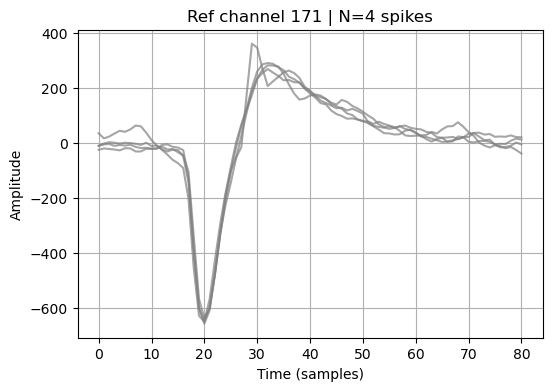

In [ ]:
import matplotlib.pyplot as plt

traces = snips_baselined[ref_channel, :, :]  # shape (T, N)

plt.figure(figsize=(6, 4))
for i in range(traces.shape[1]):
    plt.plot(traces[:, i], color='gray', alpha=0.7)

plt.title(f"Ref channel {ref_channel} | N={traces.shape[1]} spikes")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


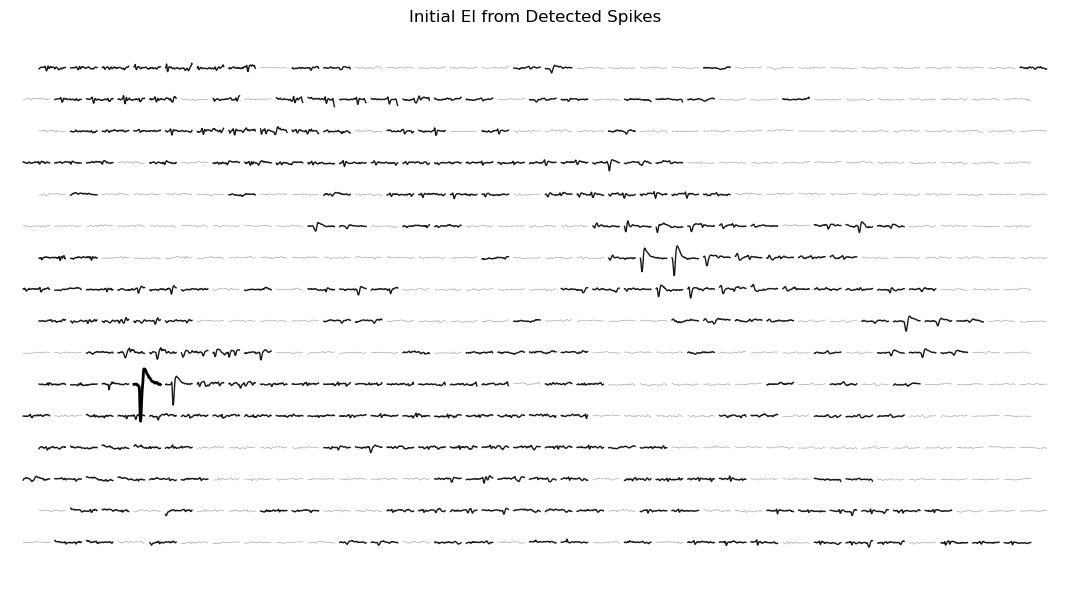

In [12]:
from plot_ei_waveforms import plot_ei_waveforms

import matplotlib.pyplot as plt

tmp_ei = np.mean(snips_baselined, axis=2)

plt.figure(figsize=(15, 6))
plot_ei_waveforms(
    ei=tmp_ei,
    positions=ei_positions,
    ref_channel = ref_channel,
    scale=70.0,
    box_height=1.0,   # can adjust for visibility
    box_width=50,
    linewidth=1,
    alpha=0.9,
    colors='black'
)
plt.title("Initial EI from Detected Spikes")
plt.tight_layout()
plt.show()

### step-by-step tracing

In [ ]:
import numpy as np
from extract_snippets_channel_major import extract_snippets_channel_major
from extract_snippets_channel_major import compute_channel_baselines_artifact
import h5py
import time
from scipy.spatial import KDTree
import json
import os


# Placeholder functions to be implemented
# These imports will fail until you define them in your script/module
from axolotl_unit_loop_utils import (
    find_dominant_channel,
    estimate_spike_threshold,
    cluster_spike_waveforms,
    select_cluster_with_largest_waveform,
    ei_pursuit,
    estimate_lags_by_xcorr,
    select_cluster_by_ei_similarity,
    subtract_pca_cluster_means,
    apply_residuals_to_channel_major,
    suppress_artifacts_in_dat,
    plot_unit_diagnostics
)

# --- Parameters ---
#dat_path = "/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat"
dat_path_chmajor = "/Volumes/Lab/Users/alexth/axolotl/201703151_data001_chmajor.dat"
n_channels = 512
dtype = 'int16'
max_units = 35
amplitude_threshold = 15
window = (-20, 60)
ei_window_len = window[1] - window[0] + 1
peak_window = 30
total_samples=36_000_000
fit_offsets = (-5, 10)


h5_in_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'  # from MATLAB export, to get EI positions
h5_out_path = '/Volumes/Lab/Users/alexth/axolotl/results_pipeline_0528.h5' # where to save data

debug_folder = "/Volumes/Lab/Users/alexth/axolotl/debug"

with h5py.File(h5_in_path, 'r') as f:
    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]




save_path = "/Volumes/Lab/Users/alexth/axolotl/201703151_data001_baseline_and_artifacts.json"

if os.path.exists(save_path):
    print(f"Loading baselines")
    with open(save_path, 'r') as f:
        data = json.load(f)
    baselines = np.array(data['baselines'], dtype=np.float32)
    artifact_locs = {int(k): v for k, v in data['artifact_locs'].items()}
else:
    print(f"Computing baselines")
    baselines, artifact_locs = compute_channel_baselines_artifact(
        dat_path_chmajor=dat_path_chmajor,
        n_channels=n_channels,
        total_samples=total_samples,
        dtype=dtype,
        segment_len=100_000,
        artifact_threshold=100.0,
        artifact_padding=1000,
        max_artifacts=5
    )

    with open(save_path, 'w') as f:
        json.dump({
            'baselines': baselines.tolist(),
            'artifact_locs': {str(k): v.tolist() if isinstance(v, np.ndarray) else v for k, v in artifact_locs.items()}
        }, f)

suppress_artifacts_in_dat(
    dat_path_chmajor=dat_path_chmajor,
    artifact_locs=artifact_locs,
    n_channels=n_channels,
    total_samples=total_samples
)

unit_id = 0



Loading baselines


Channel: 39

Threshold: 358.6040954589844

9396


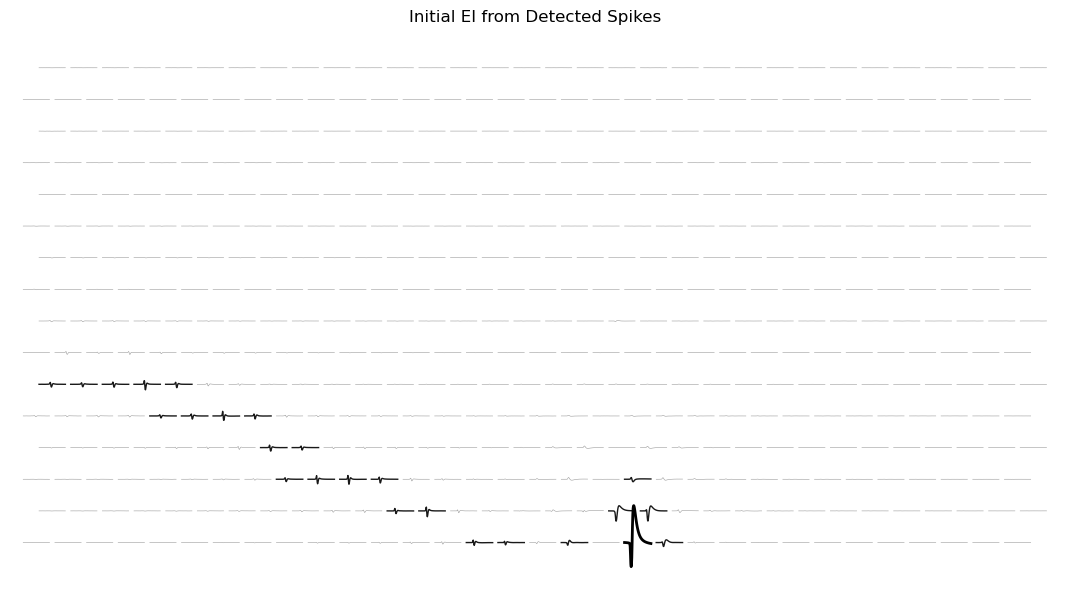

In [ ]:

# Step 1: Find dominant channel
ref_channel = find_dominant_channel(
    dat_path=dat_path_chmajor,
    n_channels=n_channels,
    dtype=dtype,          # optional if you're happy with 'int16'
    segment_len=100000,   # 5s at 20kHz
    n_segments=10,
    peak_window=peak_window, # look for post-peak maxima within ±30 samples
    top_k_neg=20,   # find this many negative peaks per channel per segment
    top_k_events=5, # use top K events per channel across all segments
    seed=42
)
print(f"Channel: {ref_channel}\n")


# Step 2–3: Estimate threshold and detect events
threshold, spike_times = estimate_spike_threshold(
    dat_path=dat_path_chmajor,
    ref_channel=ref_channel,
    dtype=dtype,
    window=peak_window,                  # ±window around neg peak to find post-peak
    n_channels=n_channels,
    total_samples_to_read=total_samples,    # could be changed to full file length
    block_size=100_000,                  # Number of timepoints per block
    refractory=30,                       # Enforce 60-sample exclusion window
    top_n=100                            # N events to estimate spike threshold
)

print(f"Threshold: {threshold}\n")
print(len(spike_times))

snips, valid_spike_times = extract_snippets_channel_major(
    dat_path_chmajor=dat_path_chmajor,
    spike_times=spike_times,
    selected_channels=np.arange(n_channels),
    window=window,
    total_samples=total_samples,
    dtype=dtype
)

# Step 5: Compute EI
ei = np.mean(snips, axis=2)
ei -= ei[:, :5].mean(axis=1, keepdims=True)

from plot_ei_waveforms import plot_ei_waveforms

import matplotlib.pyplot as plt


plt.figure(figsize=(15, 6))
plot_ei_waveforms(
    ei=ei,
    positions=ei_positions,
    ref_channel = ref_channel,
    scale=70.0,
    box_height=1.0,   # can adjust for visibility
    box_width=50,
    linewidth=1,
    alpha=0.9,
    colors='black'
)
plt.title("Initial EI from Detected Spikes")
plt.tight_layout()
plt.show()

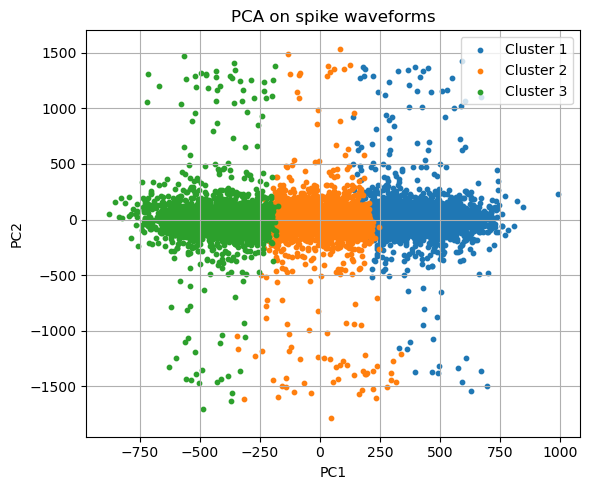

Similarity before merge:

[[1.         0.99304014 0.99404728]
 [0.99304014 0.99999994 0.99295878]
 [0.99404728 0.99295878 0.99999994]]


In [ ]:
import axolotl_unit_loop_utils
import importlib
importlib.reload(axolotl_unit_loop_utils)
# Step 6–7: Cluster and select dominant unit
clusters_pre, pcs_pre, labels_pre, sim_matrix_pre, cluster_eis_pre  = axolotl_unit_loop_utils.cluster_spike_waveforms(snips, ei, k_start=3,return_debug=True, plot_diagnostic=True)


In [ ]:

amplitudes = []
for cl in clusters_pre:
    ei = cl['ei']
    plt.figure(figsize=(15, 6))
    plot_ei_waveforms(
        ei=ei,
        positions=ei_positions,
        scale=70.0,
        box_height=1.0,   # can adjust for visibility
        box_width=50,
        linewidth=1,
        alpha=0.9,
        colors='black'
    )
    plt.title("Initial EI from Detected Spikes")
    plt.tight_layout()
    plt.show()
    sp = cl['inds']
    print(len(sp))
    p2p = ei[ref_channel, :].max() - ei[ref_channel, :].min()
    amplitudes.append(p2p)
print(amplitudes)

In [ ]:

ei, spikes_idx, selected_channels, selected_cluster_index_pre = select_cluster_with_largest_waveform(clusters_pre, ref_channel)

spikes_init = spike_times[spikes_idx]

print(len(spikes_init))

9396


In [ ]:


# Step 8: EI pursuit
(
spikes,
mean_score,
valid_score,
mean_scores_at_spikes,
valid_scores_at_spikes,
mean_thresh,
valid_thresh
) = ei_pursuit(
    dat_path=dat_path_chmajor,
    spikes=spikes_init,                     # absolute sample times
    ei_template=ei,                    # EI from selected cluster
    dtype=dtype,
    total_samples=total_samples,          # or set to actual full recording length
    save_prefix='/Volumes/Lab/Users/alexth/axolotl/ei_scan_unit0',  # set uniquely per unit
    block_size=None,                    # if None, GPU will handle this automatically
    baseline_start_sample=0,            # revisit for baseline subtraction!!! should be inside GPU
    alignment_offset = -window[0],
    fit_percentile = 40,                # how many (percentile) spikes to take to fit Gaussian for threshold determination (left-hand side of already found spikes)
    sigma_thresh = 5.0,                  # how many Gaussian sigmas to take for threshold
    channel_major = True,
    return_debug=True
)

print(len(spikes))



9386


In [ ]:
snips_ref_channel, valid_spike_times = extract_snippets_channel_major(
    dat_path_chmajor=dat_path_chmajor,
    spike_times=spikes,
    selected_channels=np.array([ref_channel]),
    window=window,
    total_samples=total_samples,
    dtype=dtype
)

snips_ref_channel = snips_ref_channel.transpose(2, 0, 1)


lags = estimate_lags_by_xcorr(
    snippets=snips_ref_channel,                # shape [N x C x T]
    peak_channel_idx=0,                 # 0 because the only channel that gets passed is the referent channel
    window=(-5, 10),                  # optional, relative to peak
    max_lag=6,                        # optional, max xcorr shift
)

lags = lags 
spikes = spikes+lags

snips_full, valid_spike_times = extract_snippets_channel_major(
    dat_path_chmajor=dat_path_chmajor,
    spike_times=spikes,
    selected_channels=np.arange(n_channels),
    window=window,
    total_samples=total_samples,
    dtype=dtype
)

segment_len = 100_000
snips_baselined = snips_full.copy()  # shape (n_channels, 81, N)
n_channels, snip_len, n_spikes = snips_baselined.shape

# Determine segment index for each spike
segment_indices = spikes // segment_len  # shape: (n_spikes,)

# Loop through channels and subtract baseline per spike
for ch in range(n_channels):
    snips_baselined[ch, :, :] -= baselines[ch, segment_indices][None, :]

# Extract baseline-subtracted waveforms for ref_channel
ref_snips = snips_baselined[ref_channel, :, :]  # shape: (81, N)

# Mean waveform over all spikes
ref_mean = ref_snips.mean(axis=1)  # shape: (81,)
# Negative peak (should be near index 20)
ref_peak_amp = np.abs(ref_mean[-window[0]])  # scalar

# Threshold at 0.5× of mean waveform peak
threshold_ampl = 0.5 * ref_peak_amp

# Get all actual spike values at sample 20
spike_amplitudes = np.abs(ref_snips[20, :])  # shape: (N,)

# Flag bad spikes: too small
bad_inds = np.where(spike_amplitudes < threshold_ampl)[0]

print(bad_inds)
print(valid_spike_times[bad_inds])



[19]
[34771]


In [14]:
print(bad_inds)

[]


In [ ]:


# Create mask to keep only good spikes
keep_mask = np.ones(spike_amplitudes.shape[0], dtype=bool)
keep_mask[bad_inds] = False

# --- Extract bad spike traces for plotting
bad_spike_traces = snips_baselined[ref_channel, :, bad_inds]  # shape: (n_bad, T)

# Get original traces for bad_spike_traces
snips_bad, disregard = extract_snippets_channel_major(
    dat_path_chmajor='/Volumes/Lab/Users/alexth/axolotl/201703151_data001_chmajor_orig.dat',
    spike_times=spikes[bad_inds],
    selected_channels=[ref_channel],
    window=window,
    total_samples=total_samples,
    dtype=dtype
)
segment_indices = spikes[bad_inds] // segment_len  # shape: (n_spikes,)
snips_bad[0, :, :] -= baselines[ref_channel, segment_indices][None, :]

# Apply to real data and snips_baselined
snips_baselined = snips_baselined[:, :, keep_mask]
good_mean_trace = np.mean(snips_baselined[ref_channel, :, :], axis=1)
snips_full = snips_full[:, :, keep_mask]
valid_spike_times = valid_spike_times[keep_mask]
spikes = spikes[keep_mask]



In [13]:

clusters_post, pcs_post, labels_post, sim_matrix_post, cluster_eis_post  = cluster_spike_waveforms(snips=snips_baselined, ei=ei, k_start=2,return_debug=True, plot_diagnostic=True)


ValueError: n_components=10 must be between 0 and min(n_samples, n_features)=4 with svd_solver='full'

In [ ]:

# Step 9c: choose the best cluster - choose similarity threshold. EI is all channels, baselined
ei, final_spike_inds, selected_channels, selected_cluster_index_post = select_cluster_by_ei_similarity(clusters=clusters_post,reference_ei=ei,similarity_threshold=0.95)


spikes = spikes[final_spike_inds]  # convert to absolute spike times

p2p_threshold = 30
ei_p2p = ei.max(axis=1) - ei.min(axis=1)
selected_channels = np.where(ei_p2p > p2p_threshold)[0]
selected_channels = selected_channels[np.argsort(ei_p2p[selected_channels])[::-1]]


In [32]:
print(spikes)
import axolotl_unit_loop_utils
import importlib
importlib.reload(axolotl_unit_loop_utils)

[28430453 24348695 32669804 24638840]


<module 'axolotl_unit_loop_utils' from '/home/alexth/python_code/Axolotl_v2/axolotl_unit_loop_utils.py'>

In [36]:
import axolotl_unit_loop_utils
import importlib
importlib.reload(axolotl_unit_loop_utils)

# DIAGNOSTIC PLOTS


pcs_post = np.zeros((1, 2))                    # shape: (N_spikes, 2 PCs)
labels_post = np.array([0])                    # just one fake cluster label
sim_matrix_post = np.zeros((1, 1))             # fake 1×1 similarity matrix
ei_clusters_post = [np.zeros((512, 81))]       # fake EI for the “post” cluster
selected_index_post = 0                        # only one cluster, so index is 0
cluster_eis_post = [np.zeros((512, 81))]       # same dummy EI
spikes_for_plot_post = np.array([0])           # placeholder spike time
spike_counts_post = [len(snips)]               # use actual number of spikes
ks_matches = []                                # no matches


axolotl_unit_loop_utils.plot_unit_diagnostics(
    output_path=debug_folder,
    unit_id=unit_id,

    # --- From first call to cluster_spike_waveforms
    pcs_pre=pcs_pre,
    labels_pre=labels_pre,
    sim_matrix_pre=sim_matrix_pre,
    ei_clusters_pre=[cl['ei'] for cl in clusters_pre],
    selected_index_pre=selected_cluster_index_pre,  # index into clusters_pre
    cluster_eis_pre = cluster_eis_pre,
    spikes_for_plot_pre = spikes_for_plot_pre,

    # --- From ei_pursuit
    mean_score=mean_score,
    valid_score=valid_score,
    mean_scores_at_spikes=mean_scores_at_spikes,
    valid_scores_at_spikes=valid_scores_at_spikes,
    mean_thresh=mean_thresh,
    valid_thresh=valid_thresh,

    # --- Lag estimation and bad spike filtering
    lags=lags,
    bad_spike_traces=bad_spike_traces,  # shape: (n_bad, T)
    good_mean_trace=good_mean_trace,
    threshold_ampl=-threshold_ampl,
    ref_channel=ref_channel,
    snips_bad=snips_bad,

    # --- From second clustering
    pcs_post=pcs_post,
    labels_post=labels_post,
    sim_matrix_post=sim_matrix_post,
    ei_clusters_post=[cl['ei'] for cl in clusters_post],
    selected_index_post=selected_cluster_index_post,
    cluster_eis_post = cluster_eis_post,
    spikes_for_plot_post = spikes_for_plot_post,

    # --- For axis labels etc.
    window=(-20, 60),

    ei_positions=ei_positions,
    selected_channels_count=len(selected_channels),

    spike_counts_pre=[len(cl['inds']) for cl in clusters_pre],
    spike_counts_post = [len(cl['inds']) for cl in clusters_post],
    spikes = spikes, 
    orig_threshold = threshold,
    ks_matches = matches
)






1
0


/home/alexth/python_code/Axolotl_v2/axolotl_unit_loop_utils.py:1574: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax7b.set_ylim(0, np.max(fractions) * 1.1)


In [47]:
print(residuals_fallback[0])

[ -7.9925766 -22.415314   38.096848   -7.688957 ]


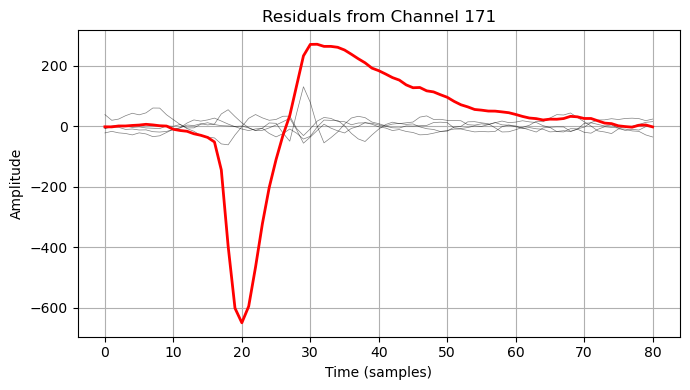

In [ ]:
# `snips_baselined` is [C x T x N]
# We only subtract on the referent channel to avoid distortion
template_fallback = np.mean(snips_baselined[ref_channel], axis=1)  # shape: (T,)
residuals_fallback = snips_baselined[ref_channel] - template_fallback[:, None]  # shape: (T, N)

plt.figure(figsize=(7,4))
for i in range(residuals_fallback.shape[1]):
    plt.plot(residuals_fallback[:,i], color='black', alpha=0.5, linewidth=0.5)

plt.plot(template_fallback, color='red', linewidth=2)
plt.title(f"Residuals from Channel {ref_channel}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# Assume residuals_fallback is (T, N) from previous step (template-subtracted waveforms)
# Transpose to match expected shape: (n_spikes, snip_len)
residual_snips_per_channel = {
    ref_channel: residuals_fallback.T.astype(np.int16)
}
selected_channels = [ref_channel]

write_locs = spikes + window[0]
apply_residuals_to_channel_major(
    dat_path_chmajor=dat_path_chmajor,
    residual_snips_per_channel=residuals_per_channel,
    write_locs=write_locs,
    selected_channels=selected_channels,
    total_samples=total_samples,
    dtype=dtype,
    n_channels=n_channels
)

In [ ]:


snips_full = snips_full[np.ix_(selected_channels, np.arange(snips_full.shape[1]), final_spike_inds)]
snips_full = snips_full.transpose(2, 0, 1) # [C × T × N] → [N × C × T]


In [ ]:
#[ 9091998 22675586 30549802 34674503]
tmp_spikes = np.array(spikes) 
targets = np.array([9091998, 22675586, 30549802, 34674503])
tolerance = 30

# Create a boolean mask for each target
matches = [np.where(np.abs(tmp_spikes - t) <= tolerance)[0] for t in targets]

# Flatten and get the actual matched spike times if needed
matched_indices = np.concatenate(matches)
matched_spikes = tmp_spikes[matched_indices]

print("Matched spike indices:", matched_indices)
print("Matched spike times:", matched_spikes)

Matched spike indices: [1283 4871 7615 8986]
Matched spike times: [ 9091976 22675565 30549781 34674482]


In [ ]:
print(selected_channels)

[ 39  43  35  91 171 166 110 118  31 159 102 172  99 170 167  79 165  55
 168  38 169 126 122  71 164 158  83 179 177  27  94  54 173  30  87  50
 107  34 125  63 115 157 114 106 163  59 180  95 174  51 162  86 151 156
 123  58 184 178  98  26  23 160 117 161]


9385


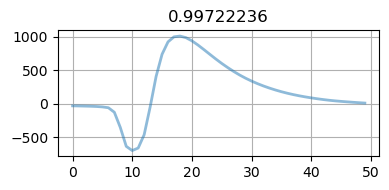

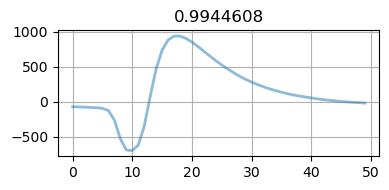

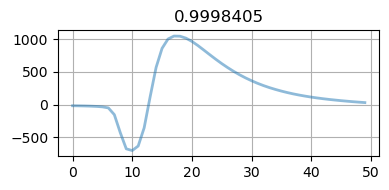

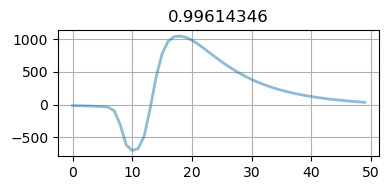

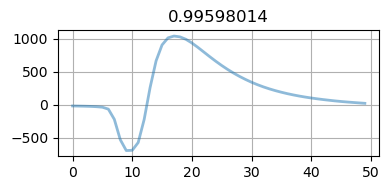

In [ ]:
import axolotl_unit_loop_utils
import importlib
importlib.reload(axolotl_unit_loop_utils)

    # --- Setup ---
residuals_per_channel = {}
cluster_ids_per_channel = {}
scale_factors_per_channel = {}

print(len(spikes))

for ch_idx, ch in enumerate(selected_channels):
    if ch==39:
        # Slice data for this channel
        ch_snips = snips_full[:, ch_idx, :]  # shape: (n_spikes, snip_len)
        ch_baselines = baselines[ch, :]    # shape: (n_segments,)
        # Subtract PCA cluster means
        residuals, scale_factors, cluster_ids = axolotl_unit_loop_utils.subtract_pca_cluster_means(
            snippets=ch_snips,
            baselines=ch_baselines,
            spike_times=spikes,
            segment_len=100_000,  # must match what was used to generate baselines
            n_clusters=5, 
            offset_window=(-10,40)
        )

        # Store results
        residuals_per_channel[ch] = residuals
        cluster_ids_per_channel[ch] = cluster_ids
        scale_factors_per_channel[ch] = scale_factors




In [ ]:
scale_factors_per_channel[179][matched_indices]
scale_factors_per_channel[39]

array([1.25, 1.25, 1.25, ..., 1.25, 1.25, 1.25], dtype=float32)

In [ ]:
scale =scale_factors_per_channel[125]

print(scale[:10])


[ 9091998 22675586 30549802 34674503]

[-1.        -1.        -1.        -1.        -1.         0.75
 -1.         0.8747354  0.914385  -1.       ]


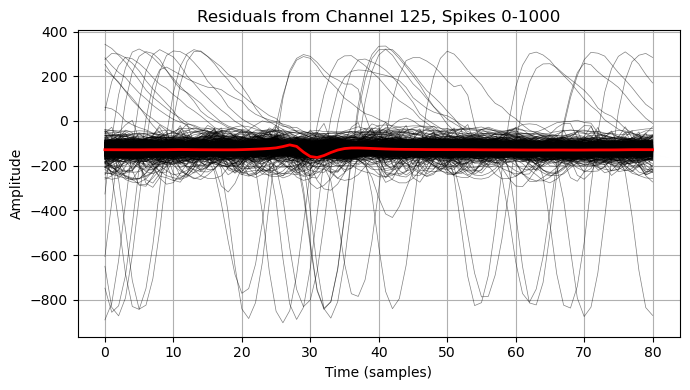

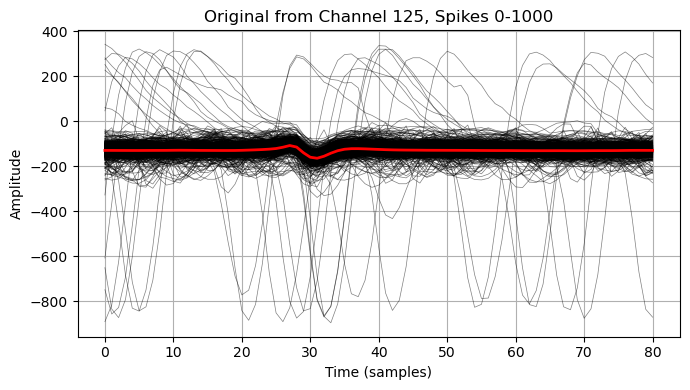

In [ ]:
import matplotlib.pyplot as plt

ch = 179

# Assume residuals_per_channel[126] is a 2D array of shape (n_samples, n_spikes)
residuals = residuals_per_channel[ch]  # shape: (T, N), e.g., (81, 9000)

# --- Define range to plot ---
start = 0
end = 1000  # or 1000-2000, etc.

residuals_chunk = residuals[start:end, :]  # shape: (1000, 81)

# Find index of channel 126 in selected_channels
ch_idx = np.where(selected_channels == ch)[0][0]  # assumes channel is present
# Slice desired spike range
snips_chunk = snips_full[start:end, ch_idx, :]  # shape: (1000, 81)
mean_waveform = snips_full[:, ch_idx, :].mean(axis=0)


plt.figure(figsize=(7,4))
for i in range(residuals_chunk.shape[0]):
    plt.plot(residuals_chunk[i], color='black', alpha=0.5, linewidth=0.5)

plt.plot(mean_waveform, color='red', linewidth=2)
plt.title(f"Residuals from Channel {ch}, Spikes {start}-{end}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(7, 4))
for i in range(snips_chunk.shape[0]):
    plt.plot(snips_chunk[i], color='black', alpha=0.5, linewidth=0.5)
plt.plot(mean_waveform, color='red', linewidth=2)
plt.title(f"Original from Channel {ch}, Spikes {start}-{end}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bad_spikes = valid_spike_times[bad_inds]

In [ ]:
from extract_data_snippets import extract_snippets

snips_test, valid_spike_times_test = extract_snippets_channel_major(
    dat_path_chmajor=dat_path_chmajor,
    spike_times=bad_spikes,
    selected_channels=np.arange(n_channels),
    window=window,
    total_samples=total_samples,
    dtype=dtype
)
print(snips_test.shape)


snips_orig = extract_snippets("/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat", bad_spikes, window=(-20, 60), n_channels=512, dtype='int16')

print(snips_orig.shape)


(512, 81, 4)
(512, 81, 4)


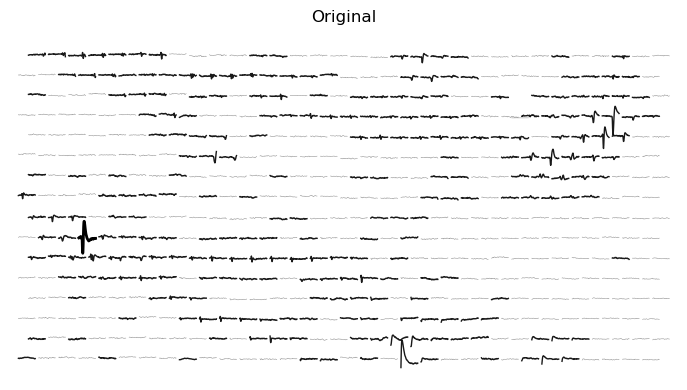

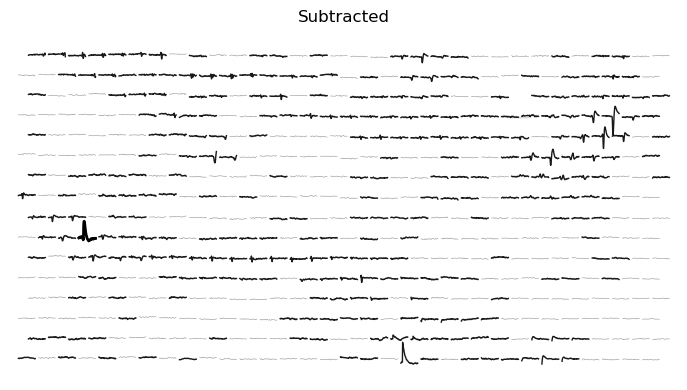

In [ ]:
ei_test = snips_orig[:, :, 0]

plt.figure(figsize=(15, 4))
plot_ei_waveforms(
    ei=ei_test,
    positions=ei_positions,
    ref_channel = ref_channel,
    scale=70.0,
    box_height=1.0,   # can adjust for visibility
    box_width=50,
    linewidth=1,
    alpha=0.9,
    colors='black'
)
plt.title("Original")
plt.tight_layout()
plt.show()

ei_test = snips_test[:, :, 0]

plt.figure(figsize=(15, 4))
plot_ei_waveforms(
    ei=ei_test,
    positions=ei_positions,
    ref_channel = ref_channel,
    scale=70.0,
    box_height=1.0,   # can adjust for visibility
    box_width=50,
    linewidth=1,
    alpha=0.9,
    colors='black'
)
plt.title("Subtracted")
plt.tight_layout()
plt.show()



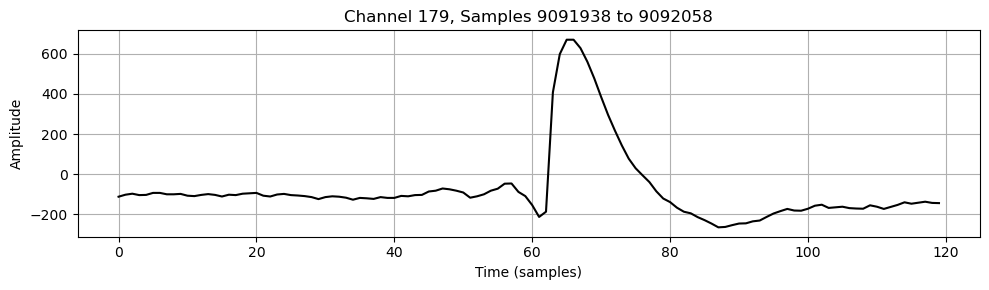

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#[ 9091998 22675586 30549802 34674503]
# --- Parameters ---
dat_path_chmajor = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_chmajor.dat'
dtype = np.int16
n_channels = 512
channel_index = 179          # Channel to extract
start_sample = 9091998-60            # Start time index (in samples)
n_samples = 120            # Number of time samples to read

# channel_index = 39          # Channel to extract
# start_sample = 1700            # Start time index (in samples)
# n_samples = 1500            # Number of time samples to read

# --- Determine total timepoints ---
file_size_bytes = np.memmap(dat_path_chmajor, dtype=dtype, mode='r').nbytes
bytes_per_sample = np.dtype(dtype).itemsize
total_samples_in_file = file_size_bytes // bytes_per_sample
total_timepoints = total_samples_in_file // n_channels

# --- Memory map full file with known shape ---
data = np.memmap(dat_path_chmajor, dtype=dtype, mode='r', shape=(n_channels, total_timepoints))

# --- Extract desired trace ---
trace = data[channel_index, start_sample:start_sample + n_samples]

# --- (Optional) Plot ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(trace, color='black')
plt.title(f"Channel {channel_index}, Samples {start_sample} to {start_sample + n_samples}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

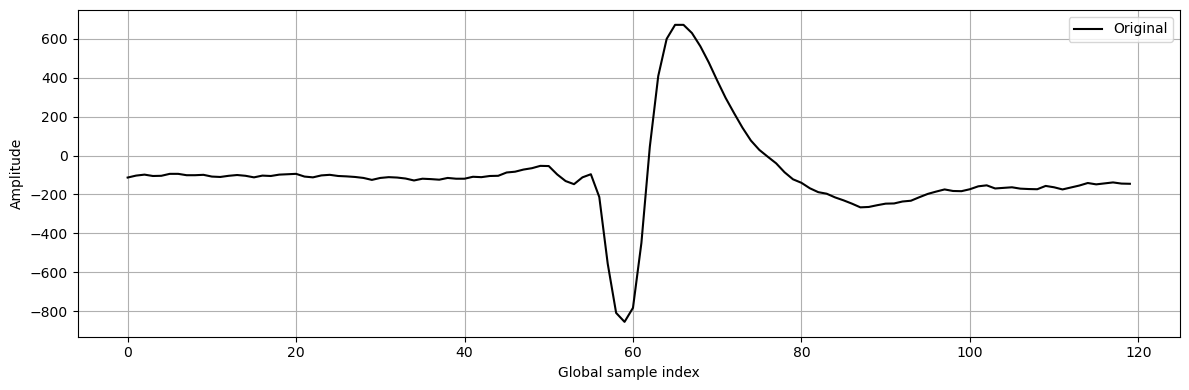

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# --- Parameters ---
channel_index = 179          # Channel to extract
start_sample = 9091998-60            # Start time index (in samples)
segment_length = 120            # Number of time samples to read
n_channels = 512
dtype = np.int16

dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'


# --- Step 1: Read unmodified segment ---
segment_offset_bytes = start_sample * n_channels * np.dtype(dtype).itemsize
segment_shape = (segment_length, n_channels)

with open(dat_path, 'rb') as f:
    f.seek(0, 2)
    file_len_bytes = f.tell()
n_total_samples = file_len_bytes // (np.dtype(dtype).itemsize * n_channels)
assert start_sample + segment_length <= n_total_samples, "Segment overflows file."

raw_mem = np.memmap(dat_path, dtype=dtype, mode='r', offset=segment_offset_bytes, shape=segment_shape)
raw_trace_original = raw_mem[:, ref_channel].astype(np.float32).copy()


plt.figure(figsize=(12, 4))
plt.plot(raw_trace_original, label="Original", color='black')
plt.xlabel("Global sample index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### read from h5 file

In [ ]:
import h5py

unit_id = 0 # or whatever unit you're checking

with h5py.File(h5_out_path, 'r') as h5:
    group = h5[f'unit_{unit_id}']
    
    spike_times = group['spike_times'][:]
    ei = group['ei'][:]
    selected_channels = group['selected_channels'][:]
    
    peak_channel = group.attrs['peak_channel']

# Check shapes or values
#print("Spike times:", spike_times.shape)
#print("EI shape:", ei.shape)
print("Selected channels:", selected_channels)
print(179 in selected_channels)
#print("Peak channel:", peak_channel)
#print(spike_times)


Selected channels: [ 39  43  35  91 171 166 110 118  31 159 102 172  99 170 167  79 165  55
 168  38 169 126 122  71 164 158  83 179 177  27  94  54 173  30  87  50
 107  34 125  63 115 157 114 106 163  59 180  95 174  51 162  86 151 156
 123  58 184 178  98  26  23 160 117 161]
True


### find matching spike pairs

In [ ]:
import numpy as np
import h5py

unit_id_1 = 3
unit_id_2 = 5
max_diff = 5  # in samples

# --- Load spike times ---
with h5py.File(h5_out_path, 'r') as h5:
    spikes_1 = h5[f'unit_{unit_id_1}']['spike_times'][:]
    spikes_2 = h5[f'unit_{unit_id_2}']['spike_times'][:]

# --- Sort spike times (for efficiency) ---
spikes_1 = np.sort(spikes_1)
spikes_2 = np.sort(spikes_2)

# --- Match spikes within max_diff ---
matches = []
j_start = 0

for i, t1 in enumerate(spikes_1):
    while j_start < len(spikes_2) and spikes_2[j_start] < t1 - max_diff:
        j_start += 1

    j = j_start
    while j < len(spikes_2) and spikes_2[j] <= t1 + max_diff:
        if abs(t1 - spikes_2[j]) <= max_diff:
            matches.append((i, j))
        j += 1

# --- Output ---
print(f"Found {len(matches)} matched spikes between unit {unit_id_1} and {unit_id_2}")
for i, j in matches:
    print(f"Spike1: {spikes_1[i]}, Spike2: {spikes_2[j]}")


Found 11 matched spikes between unit 3 and 5
Spike1: 13171094, Spike2: 13171091
Spike1: 15701576, Spike2: 15701572
Spike1: 15793995, Spike2: 15793993
Spike1: 19174347, Spike2: 19174345
Spike1: 19711708, Spike2: 19711706
Spike1: 24178709, Spike2: 24178707
Spike1: 28379138, Spike2: 28379136
Spike1: 28402248, Spike2: 28402246
Spike1: 33605702, Spike2: 33605700
Spike1: 33605702, Spike2: 33605700
Spike1: 34731206, Spike2: 34731204


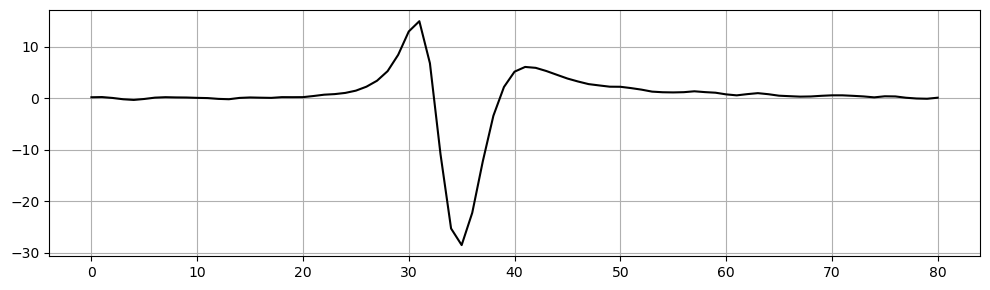

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(ei[179], color='black')
plt.grid(True)
plt.tight_layout()
plt.show()

### Plot EI from simple EI

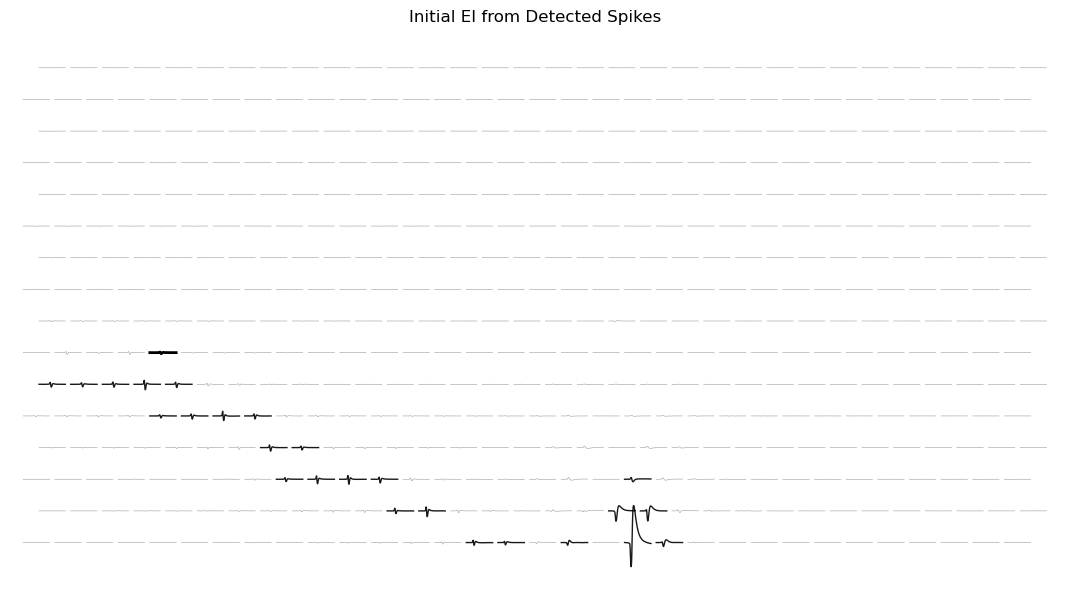

In [ ]:

from plot_ei_waveforms import plot_ei_waveforms

import matplotlib.pyplot as plt


plt.figure(figsize=(15, 6))
plot_ei_waveforms(
    ei=ei,
    positions=ei_positions,
    ref_channel=180,
    scale=70.0,
    box_height=1.0,   # can adjust for visibility
    box_width=50,
    linewidth=1,
    alpha=0.9,
    colors='black'
)
plt.title("Initial EI from Detected Spikes")
plt.tight_layout()
plt.show()

### Plot EIs from multiple clusters

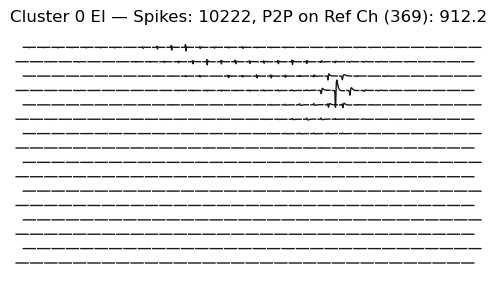

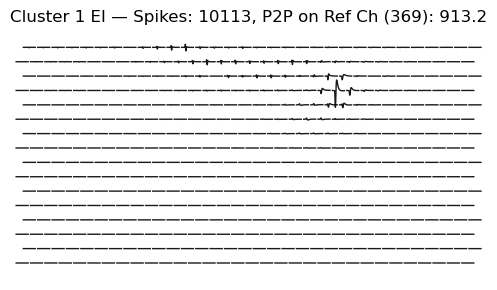

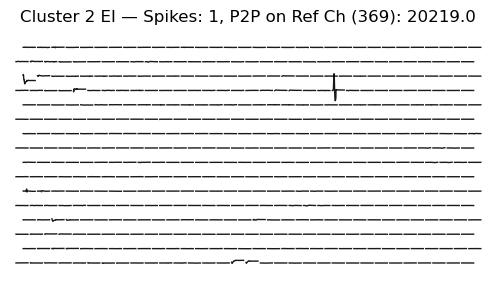

In [ ]:
from plot_ei_waveforms import plot_ei_waveforms
import matplotlib.pyplot as plt

for i, cluster in enumerate(clusters):
    ei = cluster['ei']
    ref_ch = cluster['channels'][np.argmax(np.ptp(ei[cluster['channels'], :], axis=1))]
    ei_p2p = np.ptp(ei[ref_ch, :])
    n_spikes = len(cluster['inds'])

    plt.figure(figsize=(10, 3))
    plot_ei_waveforms(
        ei=ei,
        positions=ei_positions,
        scale=70.0,
        box_height=1.0,
        box_width=50,
        linewidth=1,
        alpha=0.9,
        colors='black'
    )
    plt.title(f"Cluster {i} EI — Spikes: {n_spikes}, P2P on Ref Ch ({ref_ch}): {ei_p2p:.1f}")
    plt.tight_layout()
    plt.show()



### Testing

### Read and plot samples from channel-major file

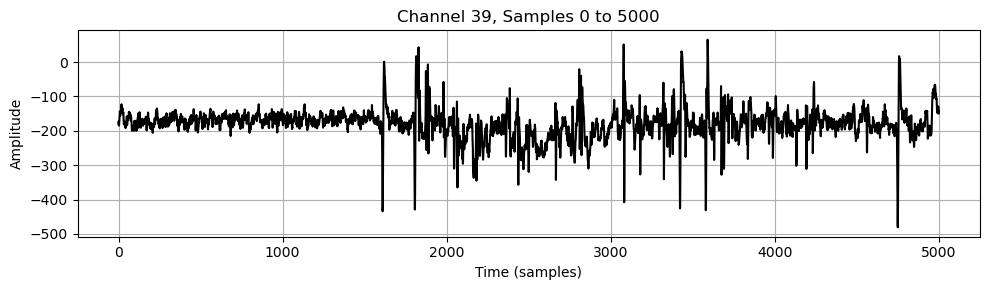

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

# --- Parameters ---
dat_path_chmajor = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_chmajor.dat'
dtype = np.int16
n_channels = 512
channel_index = 39          # Channel to extract
start_sample = 0            # Start time index (in samples)
n_samples = 5000            # Number of time samples to read

# --- Determine total timepoints ---
file_size_bytes = np.memmap(dat_path_chmajor, dtype=dtype, mode='r').nbytes
bytes_per_sample = np.dtype(dtype).itemsize
total_samples = file_size_bytes // bytes_per_sample
total_timepoints = total_samples // n_channels

# --- Memory map full file with known shape ---
data = np.memmap(dat_path_chmajor, dtype=dtype, mode='r', shape=(n_channels, total_timepoints))

# --- Extract desired trace ---
trace = data[channel_index, start_sample:start_sample + n_samples]

# --- (Optional) Plot ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(trace, color='black')
plt.title(f"Channel {channel_index}, Samples {start_sample} to {start_sample + n_samples}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

window = (-30, 50)
win_left, win_right = window
n_channels = 512  # or however many you have

data = np.memmap(dat_path_chmajor, dtype=np.int16, mode='r', shape=(n_channels, total_samples))

import matplotlib.pyplot as plt

win_left, win_right = window
window_size = win_right - win_left
ncols = 5
snips_to_plot = [(ch, s) for ch, locs in artifact_locs.items() for s in locs]
n = len(snips_to_plot)
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 2))
axes = axes.flatten()

for i, (ch, s) in enumerate(snips_to_plot):
    ax = axes[i]
    start = s + win_left
    end = s + win_right
    if start < 0 or end > data.shape[1]:
        ax.set_title(f"Channel {ch}, Sample {s} (OOB)")
        ax.axis('off')
        continue
    snippet = data[ch, start:end]
    ax.plot(np.arange(window_size), snippet)
    ax.set_title(f"Ch {ch}, Samp {s}", fontsize=8)
    ax.tick_params(labelsize=6)

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# --- Parameters ---
ref_channel = 39
start_sample = 0       # start of segment
segment_length = 5000        # number of samples
n_channels = 512
dtype = np.int16

dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat'


# --- Step 1: Read unmodified segment ---
segment_offset_bytes = start_sample * n_channels * np.dtype(dtype).itemsize
segment_shape = (segment_length, n_channels)

with open(dat_path, 'rb') as f:
    f.seek(0, 2)
    file_len_bytes = f.tell()
n_total_samples = file_len_bytes // (np.dtype(dtype).itemsize * n_channels)
assert start_sample + segment_length <= n_total_samples, "Segment overflows file."

raw_mem = np.memmap(dat_path, dtype=dtype, mode='r', offset=segment_offset_bytes, shape=segment_shape)
raw_trace_original = raw_mem[:, ref_channel].astype(np.float32).copy()


plt.figure(figsize=(12, 4))
plt.plot(raw_trace_original, label="Original", color='black')
plt.xlabel("Global sample index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
from axolotl_unit_loop_utils import find_dominant_channel

dat_path = "/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat"
n_channels = 512
dtype = 'int16'

ref_channel = find_dominant_channel(
    dat_path=dat_path,
    n_channels=n_channels,
    dtype=dtype,          # optional if you're happy with 'int16'
    segment_len=100000,   # 5s at 20kHz
    n_segments=10,
    peak_window=30, # look for post-peak maxima within ±30 samples
    top_k_neg=20,   # find this many negative peaks per channel per segment
    top_k_events=5, # use top K events per channel across all segments
    seed=42
)

print(f"Dominant channel: {ref_channel}")


In [ ]:
from axolotl_unit_loop_utils import estimate_spike_threshold

dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat'
ref_channel = 39  # or use the result from find_dominant_channel
dtype = 'int16'
window = 30 

threshold, spike_times = estimate_spike_threshold(
    dat_path=dat_path,
    ref_channel=ref_channel,
    dtype=dtype,
    window=window,
    n_channels=512,
    total_samples_to_read=10_000_000,
    block_size=100_000,
    refractory=30,
    top_n=100
)

print(f"Estimated threshold: {threshold:.2f}")
print(f"Number of suprathreshold events: {len(spike_times)}")


In [ ]:
import numpy as np
from extract_data_snippets import extract_snippets
from plot_ei_waveforms import plot_ei_waveforms
import h5py

h5_in_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_kilosort_data001_spike_times.h5'  # from MATLAB export

with h5py.File(h5_in_path, 'r') as f:
    # Load electrode positions
    ei_positions = f['/ei_positions'][:].T  # shape becomes [512 x 2]

# --- Parameters ---
dat_path = "/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat"
n_channels = 512
dtype = 'int16'
max_units = 500
amplitude_threshold = 15
window = (-20, 60)
ei_window_len = window[1] - window[0] + 1
peak_window = 30
window = (-20, 60)

snips = extract_snippets(dat_path, spike_times, window, n_channels, dtype)

    # Step 5: Compute EI
ei = np.mean(snips, axis=2)
ei -= ei[:, :5].mean(axis=1, keepdims=True)


In [ ]:
import axolotl_unit_loop_utils
import importlib
importlib.reload(axolotl_unit_loop_utils)
ref_channel = 39
clusters = axolotl_unit_loop_utils.cluster_spike_waveforms(snips, ei, k_start=3)
ei, spikes, selected_channels = axolotl_unit_loop_utils.select_cluster_with_largest_waveform(clusters, ref_channel)

len(spikes)
spikes = spike_times[spikes]

In [ ]:
import axolotl_unit_loop_utils
import importlib
importlib.reload(axolotl_unit_loop_utils)


spikes = axolotl_unit_loop_utils.ei_pursuit(
    dat_path=dat_path,
    spikes=spikes,                     # absolute sample times
    ei_template=ei,                    # EI from selected cluster
    dtype=dtype,
    total_samples=10_000_000,          # or set to actual full recording length
    save_prefix='/Volumes/Lab/Users/alexth/axolotl/ei_scan_unit0',  # set uniquely per unit
    block_size=None,
    baseline_start_sample=0,            # revisit for baseline subtraction!!! should be inside GPU
    alignment_offset = -window[0],
    fit_percentile = 40,                # how many (percentile) spikes to take to fit Gaussian for threshold determination (left-hand side of already found spikes)
    sigma_thresh = 5.0                  # how many Gaussian sigmas to take for threshold
)

    
print(f"Detected {len(spikes)} spikes after EI pursuit.")


In [ ]:
from extract_data_snippets import extract_snippets
import axolotl_unit_loop_utils
import importlib
importlib.reload(axolotl_unit_loop_utils)

    # Step 1: Extract full snippets from final spike times
snips_full = extract_snippets(
        dat_path=dat_path,
        spike_times=spikes,          # these are real spike times (sample indices)
        window=window,
        n_channels=512,
        dtype=dtype
)

    # Step 2: Recluster
clusters = axolotl_unit_loop_utils.cluster_spike_waveforms(
        snips=snips_full,
        ei=ei,                       # from earlier template cluster
        k_start=2                    # or however many clusters you want to try
)

In [ ]:
import axolotl_unit_loop_utils
import importlib
importlib.reload(axolotl_unit_loop_utils)

ei, final_spike_inds, selected_channels = axolotl_unit_loop_utils.select_cluster_by_ei_similarity(
    clusters=clusters,
    reference_ei=ei,
    similarity_threshold=0.9
)

spikes = spikes[final_spike_inds]  # convert to absolute spike times
snips = snips_full[:, :, final_spike_inds]  # update snippet block

print(spikes)
print(len(spikes))


In [ ]:
for i, cl in enumerate(clusters):
    print(f"Cluster {i}: {len(cl['inds'])} spikes, EI shape = {cl['ei'].shape}, channels = {len(cl['channels'])}")


In [ ]:
import axolotl_unit_loop_utils
import importlib
importlib.reload(axolotl_unit_loop_utils)


# --- Parameters ---
channel_idx = 39  # channel you want to process
dtype = np.int16
n_channels = 512
window = (-20, 60)
fit_offsets = (-5, 10)
total_samples = 36000000  # update based on your .dat file
dat_path_chmajor = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_chmajor.dat'

# Optional
diagnostic_spikes = spikes[[0,1,5]] if len(spikes) > 2 else None

# Run
fit_params, residual_snippets, write_locs = axolotl_unit_loop_utils.run_template_subtraction_on_channel_accumulate(
    channel_idx=channel_idx,
    final_spike_times=spikes,
    ei_waveform=ei[channel_idx],
    dat_path_chmajor=dat_path_chmajor,
    total_samples=total_samples,
    dtype=dtype,
    window=window,
    fit_offsets=fit_offsets,
    max_chunk_len=100_000,  # 5 seconds @ 20 kHz
    fallback_fit_params=None,  # or supply dict if desired
    diagnostic_plot_spikes=diagnostic_spikes
)


In [ ]:
import matplotlib.pyplot as plt

# Example spike indices into residual_snippets
plot_spike_indices = list(range(50))

plt.figure(figsize=(10, 5))
for idx in plot_spike_indices:
    plt.plot(residual_snippets[idx], label=f"Spike {idx}", alpha=0.7)

plt.title(f"Residual snippets for channel {channel_idx}")
plt.xlabel("Sample index (relative to spike)")
plt.ylabel("Amplitude (int16)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
channel = 43  # replace with actual channel index
start_sample = 1700
end_sample = 3000
n_channels = 512
dtype = np.int16

# File paths
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'
sub_dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat'

def read_channel_segment(path, ch, start, end, n_channels, dtype):
    num_samples = end - start
    offset = start * n_channels * np.dtype(dtype).itemsize
    with open(path, 'rb') as f:
        f.seek(offset)
        raw = np.fromfile(f, dtype=dtype, count=num_samples * n_channels)
    data = raw.reshape((num_samples, n_channels))
    return data[:, ch]

# Read both versions
raw_segment = read_channel_segment(dat_path, channel, start_sample, end_sample, n_channels, dtype)
sub_segment = read_channel_segment(sub_dat_path, channel, start_sample, end_sample, n_channels, dtype)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(raw_segment, label='Original', alpha=0.6)
plt.plot(sub_segment, label='Subtracted', alpha=0.6)
plt.xlabel('Sample index')
plt.ylabel('Raw value')
plt.title(f'Channel {channel}, Samples {start_sample}–{end_sample}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
channel = 43  # replace with actual channel index
start_sample = 1700
end_sample = 3000
n_channels = 512
dtype = np.int16

# File paths
dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001.dat'
sub_dat_path = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_sub.dat'

def read_channel_segment(path, ch, start, end, n_channels, dtype):
    num_samples = end - start
    offset = start * n_channels * np.dtype(dtype).itemsize
    with open(path, 'rb') as f:
        f.seek(offset)
        raw = np.fromfile(f, dtype=dtype, count=num_samples * n_channels)
    data = raw.reshape((num_samples, n_channels))
    return data[:, ch]

# Read both versions
raw_segment = read_channel_segment(dat_path, channel, start_sample, end_sample, n_channels, dtype)
sub_segment = read_channel_segment(sub_dat_path, channel, start_sample, end_sample, n_channels, dtype)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(raw_segment, label='Original', alpha=0.6)
plt.plot(sub_segment, label='Subtracted', alpha=0.6)
plt.xlabel('Sample index')
plt.ylabel('Raw value')
plt.title(f'Channel {channel}, Samples {start_sample}–{end_sample}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#start_time = time.time()

import axolotl_unit_loop_utils
import importlib
importlib.reload(axolotl_unit_loop_utils)


if 1:
    # Step 11: accumulate edits (subtracted spike residuals)
    # --- Setup ---
    p2p_threshold = 15
    ei_p2p = ei.max(axis=1) - ei.min(axis=1)
    selected_channels = np.where(ei_p2p > p2p_threshold)[0]
    selected_channels = selected_channels[np.argsort(ei_p2p[selected_channels])[::-1]]
    tree = KDTree(ei_positions)

    #spikes = spikes[:5]

    # Precompute valid spikes (for fallback and range checks)
    valid_spikes = [s for s in spikes if (s + window[0] >= 0) and (s + window[1] < total_samples)]
    valid_spikes = np.array(valid_spikes)

    #selected_channels = [39]

    # Accumulators
    all_channel_fit_params = {ch: None for ch in selected_channels}
    all_residual_snips = {}
    all_write_locs = {}

    for ch_idx in selected_channels:

        # Neighbor search
        ch_coord = ei_positions[ch_idx]
        neighbor_dists, neighbor_idxs = tree.query(ch_coord, k=6)
        neighbor_idxs = neighbor_idxs[neighbor_dists > 0]

        # Collect fallback parameters if available
        valid_neighbors = [idx for idx in neighbor_idxs if all_channel_fit_params.get(idx) is not None]
        if valid_neighbors:
            fallback_params = {}
            for i, spike_time in enumerate(valid_spikes):
                per_spike_vals = [all_channel_fit_params[idx][i] for idx in valid_neighbors]
                fallback_params[spike_time] = np.mean(per_spike_vals, axis=0)
        else:
            fallback_params = None

        # Run subtraction
        fit_params, residual_snippets, write_locs = axolotl_unit_loop_utils.run_template_subtraction_on_channel_accumulate(
            channel_idx=ch_idx,
            final_spike_times=spikes,
            ei_waveform=ei[ch_idx],
            dat_path_chmajor=dat_path_chmajor,
            total_samples=total_samples,
            dtype=dtype,
            window=window,
            fit_offsets=fit_offsets,
            max_chunk_len=100_000,  # 5s @ 20kHz
            fallback_fit_params=fallback_params,
            diagnostic_plot_spikes=None
        )
        

        # Store results
        all_channel_fit_params[ch_idx] = fit_params
        all_residual_snips[ch_idx] = residual_snippets
        all_write_locs[ch_idx] = write_locs

        end_time = time.time()
        elapsed = end_time - start_time
        print(f"Processed channel {ch_idx} with {len(spikes)} spikes in {elapsed:.1f} seconds.")

    print("Template subtraction complete.")


In [ ]:

import extract_snippets_channel_major
import importlib
importlib.reload(extract_snippets_channel_major)

p2p_threshold = 25
ei_p2p = ei.max(axis=1) - ei.min(axis=1)
selected_channels = np.where(ei_p2p > p2p_threshold)[0]
selected_channels = selected_channels[np.argsort(ei_p2p[selected_channels])[::-1]]
print(len(selected_channels))

snippets, valid_spike_times = extract_snippets_channel_major.extract_snippets_channel_major(
    dat_path_chmajor='/Volumes/Lab/Users/alexth/axolotl/201703151_data001_chmajor.dat',
    spike_times=spikes,
    selected_channels=selected_channels,
    window=window,
    total_samples=36_000_000,
    dtype=dtype
)

75
Extracting 9383 valid spike snippets from 75 channels...


In [ ]:
baselines = extract_snippets_channel_major.compute_channel_baselines(
    dat_path_chmajor=dat_path_chmajor,
    n_channels=512,
    total_samples=36_000_000,
    dtype=dtype,
    segment_len=100_000
)

In [ ]:

import axolotl_unit_loop_utils
import importlib
importlib.reload(axolotl_unit_loop_utils)


# --- Setup ---
residuals_per_channel = {}
cluster_ids_per_channel = {}
scale_factors_per_channel = {}

for ch_idx, ch in enumerate(selected_channels):
    # Slice data for this channel
    ch_snips = snippets[:, ch_idx, :]  # shape: (n_spikes, snip_len)
    ch_baselines = baselines[ch, :]    # shape: (n_segments,)

    # Subtract PCA cluster means
    residuals, cluster_ids, scale_factors = axolotl_unit_loop_utils.subtract_pca_cluster_means(
        snippets=ch_snips,
        baselines=ch_baselines,
        spike_times=valid_spike_times,
        segment_len=100_000,  # must match what was used to generate baselines
        n_clusters=5
    )

    # Store results
    residuals_per_channel[ch] = residuals
    cluster_ids_per_channel[ch] = cluster_ids
    scale_factors_per_channel[ch] = scale_factors



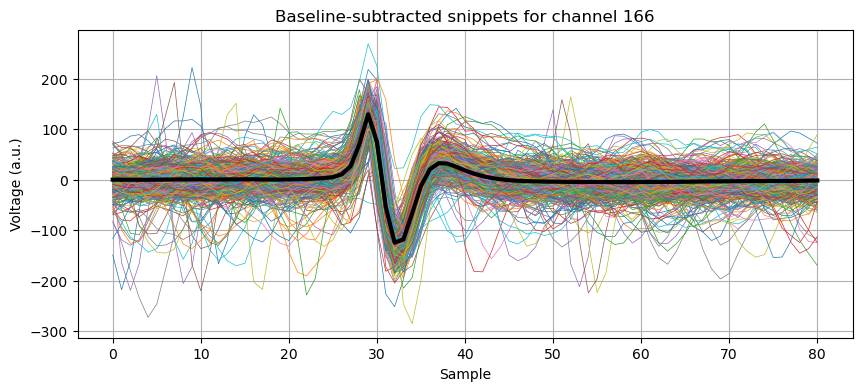

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# --- Setup ---
channel = 166
segment_len = 100_000  # 5 seconds
assert channel in selected_channels, f"Channel {channel} not in selected_channels"
ch_idx = selected_channels.tolist().index(channel) # index into snippets array

# --- Compute baseline index for each spike ---
baseline_indices = valid_spike_times // segment_len  # shape: (9383,)
channel_baselines = baselines[channel, baseline_indices]  # shape: (9383,)

# --- Subtract and plot ---
baseline_subtracted_snips = snippets[:, ch_idx, :] - channel_baselines[:, None]

# Compute mean waveform
mean_waveform = np.mean(baseline_subtracted_snips, axis=0)

# Example: plot first 5
plt.figure(figsize=(10, 4))
plt.plot(baseline_subtracted_snips[:500].T, linewidth=0.5)
plt.plot(mean_waveform, color="black", linewidth=3)
plt.title(f"Baseline-subtracted snippets for channel {channel}")
plt.xlabel("Sample")
plt.ylabel("Voltage (a.u.)")
plt.grid(True)
plt.show()


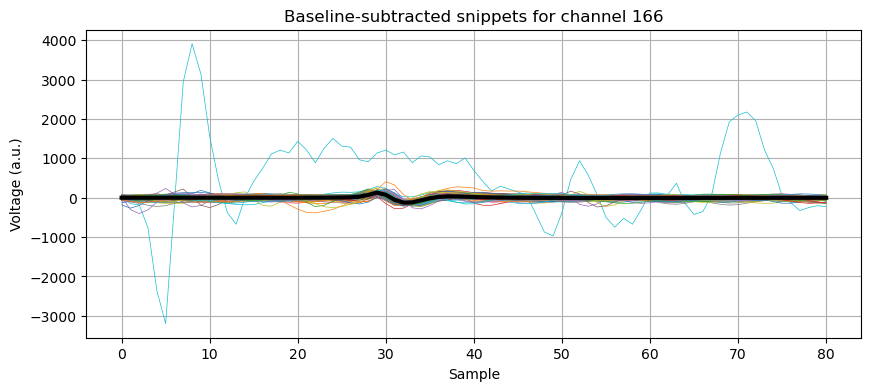

In [ ]:
template = mean_waveform  # ensure same preprocessing as in EI prep
template_power = np.dot(template, template)  # scalar

# Compute scaling factors (one per spike)
scales = baseline_subtracted_snips @ template / template_power  # shape: (n_spikes,)

# Optionally reconstruct scaled fits:
scaled_snips = baseline_subtracted_snips / scales[:, np.newaxis]

plt.figure(figsize=(10, 4))
plt.plot(scaled_snips[:500].T, linewidth=0.5)
plt.plot(mean_waveform, color="black", linewidth=3)
plt.title(f"Baseline-subtracted snippets for channel {channel}")
plt.xlabel("Sample")
plt.ylabel("Voltage (a.u.)")
plt.grid(True)
plt.show()


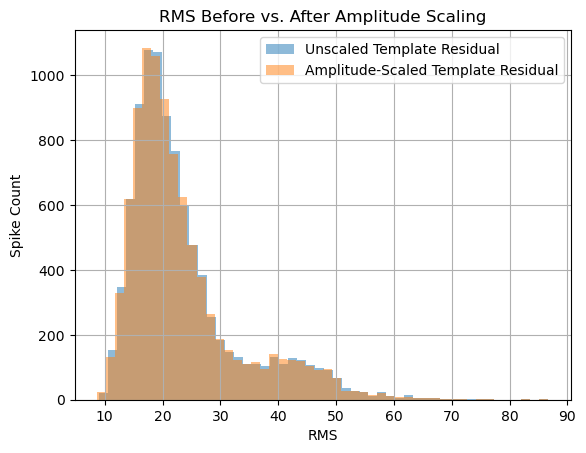

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assumes the following are already defined:
# - baseline_subtracted_snips: shape (n_spikes, snip_len)
# - template: 1D array of shape (snip_len,)

# Amplitude fits
A_fits = np.sum(baseline_subtracted_snips * template, axis=1) / np.sum(template ** 2)

# Unscaled residuals
residuals_unscaled = baseline_subtracted_snips - template[None, :]

# Scaled template per spike
scaled_templates = A_fits[:, None] * template[None, :]
residuals_scaled = baseline_subtracted_snips - scaled_templates

# RMS per spike
rms_unscaled = np.sqrt(np.mean(residuals_unscaled ** 2, axis=1))
rms_scaled = np.sqrt(np.mean(residuals_scaled ** 2, axis=1))

# Plot histograms
plt.hist(rms_unscaled, bins=50, alpha=0.5, label='Unscaled Template Residual')
plt.hist(rms_scaled, bins=50, alpha=0.5, label='Amplitude-Scaled Template Residual')
plt.xlabel('RMS')
plt.ylabel('Spike Count')
plt.legend()
plt.title('RMS Before vs. After Amplitude Scaling')
plt.grid(True)
plt.show()

In [ ]:
from scipy.signal import correlate

peak_sample = 20
shift_range = (-5, 10)  # relative to peak

# Define window for xcorr comparison
xcorr_window = np.arange(peak_sample + shift_range[0], peak_sample + shift_range[1])
template_seg = template[xcorr_window]
template_seg = (template_seg - np.mean(template_seg)) / (np.std(template_seg) + 1e-9)

n_spikes, snip_len = scaled_snips.shape
aligned_snips = np.zeros_like(scaled_snips)
shifts = np.zeros(n_spikes, dtype=int)

for i in range(n_spikes):
    snip = scaled_snips[i]
    snip_seg = snip[xcorr_window]
    snip_seg_norm = (snip_seg - np.mean(snip_seg)) / (np.std(snip_seg) + 1e-9)

    # Compute cross-correlation only within the window
    xcorr = correlate(snip_seg_norm, template_seg, mode='full')
    center = len(xcorr) // 2
    lag_range = np.arange(shift_range[0], shift_range[1])

    # Get subset of xcorr within allowed lags
    allowed_lags = lag_range[(center + lag_range >= 0) & (center + lag_range < len(xcorr))]
    lag_values = xcorr[center + allowed_lags]

    best_rel_shift = allowed_lags[np.argmax(lag_values)]
    shifts[i] = best_rel_shift

    # Apply shift to full snippet
    if best_rel_shift < 0:
        aligned_snips[i, :best_rel_shift] = snip[-best_rel_shift:]
    elif best_rel_shift > 0:
        aligned_snips[i, best_rel_shift:] = snip[:-best_rel_shift]
    else:
        aligned_snips[i] = snip

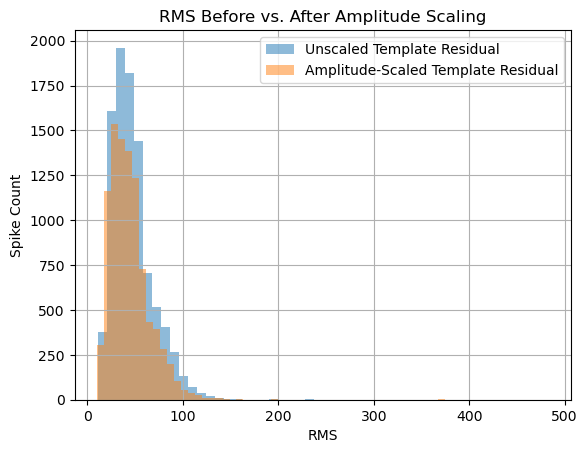

In [ ]:
residuals_scaled = baseline_subtracted_snips - scaled_templates
residuals_shifted = baseline_subtracted_snips - aligned_snips
# RMS per spike
rms_unscaled = np.sqrt(np.mean(residuals_unscaled ** 2, axis=1))
rms_scaled = np.sqrt(np.mean(residuals_scaled ** 2, axis=1))

# Plot histograms
plt.hist(rms_unscaled, bins=50, alpha=0.5, label='Unscaled Template Residual')
plt.hist(rms_scaled, bins=50, alpha=0.5, label='Amplitude-Scaled Template Residual')
plt.xlabel('RMS')
plt.ylabel('Spike Count')
plt.legend()
plt.title('RMS Before vs. After Amplitude Scaling')
plt.grid(True)
plt.show()

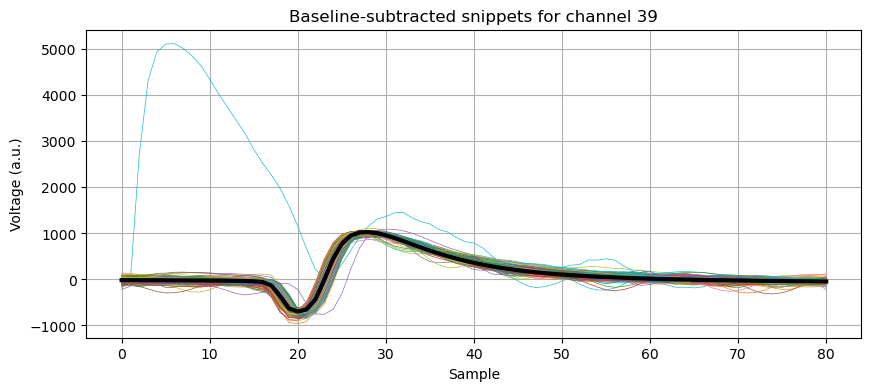

In [ ]:

plt.figure(figsize=(10, 4))
plt.plot(aligned_snips[:500].T, linewidth=0.5)
plt.plot(mean_waveform, color="black", linewidth=3)
plt.title(f"Baseline-subtracted snippets for channel {channel}")
plt.xlabel("Sample")
plt.ylabel("Voltage (a.u.)")
plt.grid(True)
plt.show()

Cluster 0: 2392 spikes
Cluster 1: 1829 spikes
Cluster 2: 1682 spikes
Cluster 3: 2192 spikes
Cluster 4: 1288 spikes


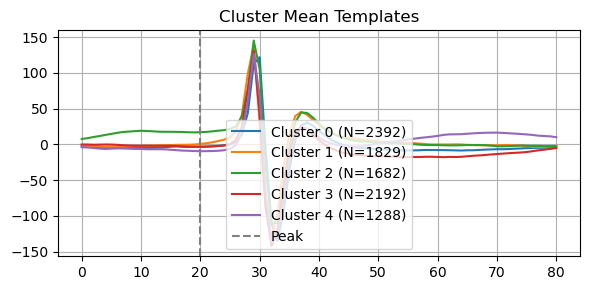

21.270527020911477


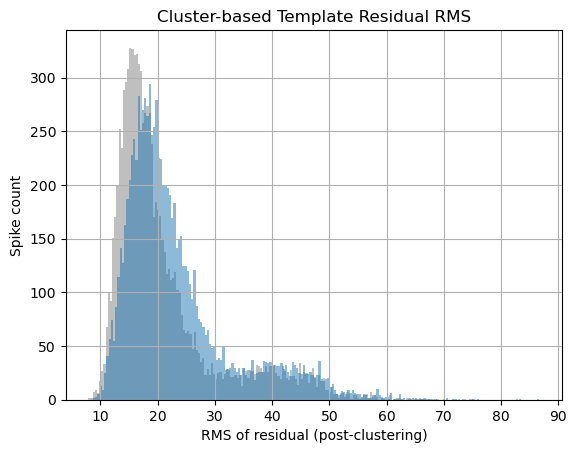

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Inputs:
# - baseline_subtracted_snips: shape (n_spikes, snip_len)
# - template: shape (snip_len,)
# Assumes: template has already been baseline corrected

# Step 1: amplitude scale each snippet
template = template - np.mean(template[:5])
A_fits = np.sum(baseline_subtracted_snips * template, axis=1) / np.sum(template ** 2)
#scaled_snips = A_fits[:, None] * template[None, :]
scaled_snips = baseline_subtracted_snips  # leave unscaled and cluster raw residual shape


# Step 2: PCA
pca = PCA(n_components=10)
proj = pca.fit_transform(scaled_snips)

n_clusters = 5
# Step 3: KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(proj)

# Step 4: compute residuals from cluster means
residuals = np.zeros_like(scaled_snips)
rms_residuals = np.zeros(scaled_snips.shape[0])

for k in range(n_clusters):
    count = np.sum(cluster_labels == k)
    print(f"Cluster {k}: {count} spikes")

plt.figure(figsize=(6, 3))
for k in range(n_clusters):
    cluster_mask = (cluster_labels == k)
    cluster_snips = scaled_snips[cluster_mask]
    if len(cluster_snips) == 0:
        continue
    cluster_mean = np.mean(cluster_snips, axis=0)
        # Plot mean waveform for this cluster
    plt.plot(cluster_mean, label=f'Cluster {k} (N={len(cluster_snips)})')
    residuals[cluster_mask] = scaled_snips[cluster_mask] - cluster_mean
    rms_residuals[cluster_mask] = np.sqrt(np.mean((scaled_snips[cluster_mask] - cluster_mean[None, :]) ** 2, axis=1))

plt.title("Cluster Mean Templates")
plt.axvline(20, linestyle='--', color='gray', label='Peak')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(np.mean(rms_residuals))
# Step 5: visualize RMS
plt.hist(rms_residuals, bins=200, color='gray', alpha=0.5, label='PCA Template Residual')
plt.hist(rms_scaled, bins=200, alpha=0.5, label='Amplitude-Scaled Template Residual')
plt.xlabel('RMS of residual (post-clustering)')
plt.ylabel('Spike count')
plt.title('Cluster-based Template Residual RMS')
plt.grid(True)
plt.show()


In [ ]:
print(cluster_labels[1])

4


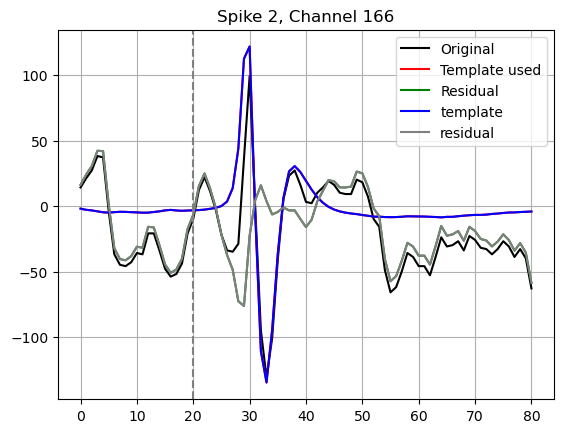

In [ ]:
template_recon = baseline_subtracted_snips - residuals

i = 2  # or any other spike index

k = cluster_labels[i]
cluster_mask = (cluster_labels == k)
cluster_snips = scaled_snips[cluster_mask]
cluster_mean = np.mean(cluster_snips, axis=0)

plt.plot(baseline_subtracted_snips[i,:], label='Original', color='black')
plt.plot(template_recon[i,:], label='Template used', color='red')
plt.plot(residuals[i,:], label='Residual', color='green')
plt.plot(cluster_mean, label='template', color='blue')
plt.plot(baseline_subtracted_snips[i,:]-cluster_mean, label='residual', color='gray')
plt.axvline(20, linestyle='--', color='gray')
plt.legend()
plt.grid(True)
plt.title(f'Spike {i}, Channel {channel}')
plt.show()


In [ ]:
import numpy as np
from scipy.interpolate import interp1d

# --- Prep ---
snip_len = baseline_subtracted_snips.shape[1]
t_orig = np.arange(snip_len)
template = template.astype(np.float32)

# --- Define transforms ---
warp_factors = [0.9, 0.95, 1, 1.05, 1.1]
shifts = [-1, -0.5, 0, 0.5, 1]
template_options = []

for warp in warp_factors:
    for shift in shifts:
        t_warped = (t_orig - snip_len // 2 - shift) / warp + snip_len // 2
        t_warped = np.clip(t_warped, 0, snip_len - 1)
        interp_func = interp1d(t_orig, template, kind='cubic', bounds_error=False, fill_value="extrapolate")
        warped_template = interp_func(t_warped)
        template_options.append(warped_template)

template_options = np.stack(template_options)  # shape: (8, snip_len)


In [ ]:
# --- Compute residuals for each template option ---
# baseline_subtracted_snips: (n_spikes, snip_len)
# template_options: (8, snip_len)

precom_residuals = baseline_subtracted_snips[:, None, :] - template_options[None, :, :]
rms_errors = np.sqrt(np.mean(precom_residuals**2, axis=-1))  # (n_spikes, 8)
best_idx = np.argmin(rms_errors, axis=1)
best_residuals = precom_residuals[np.arange(len(baseline_subtracted_snips)), best_idx, :]

print("Residuals shape:", best_residuals.shape)  # (n_spikes, snip_len)


Residuals shape: (9383, 81)


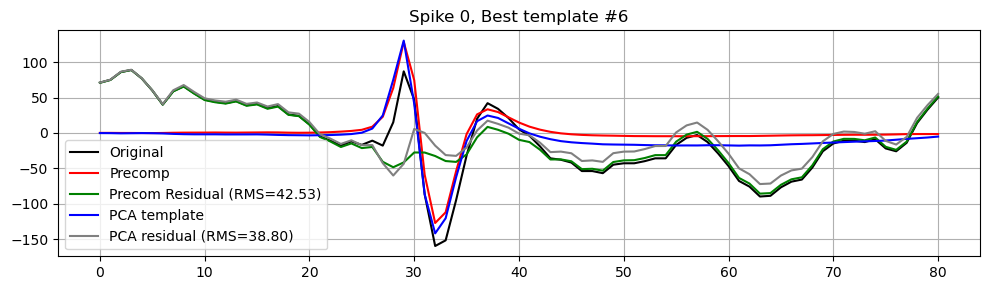

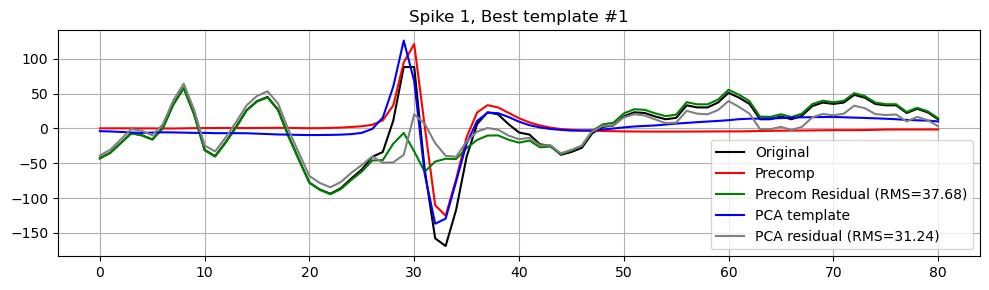

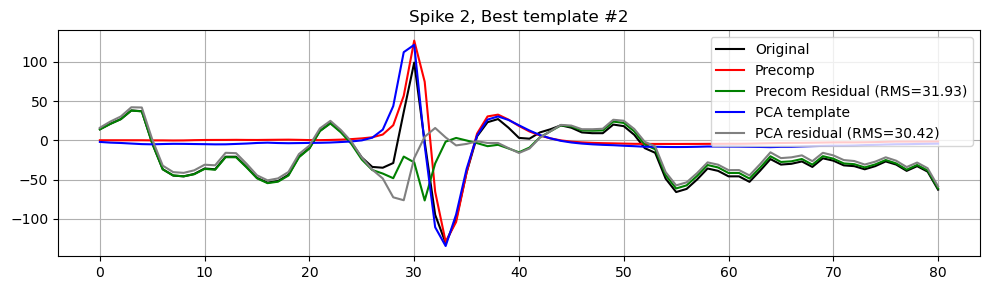

In [ ]:
import matplotlib.pyplot as plt
from numpy.linalg import norm
template_recon = baseline_subtracted_snips - residuals


for i in range(3):
    rms = np.sqrt(np.mean(best_residuals[i] ** 2))
    k = cluster_labels[i]
    cluster_mask = (cluster_labels == k)
    cluster_snips = scaled_snips[cluster_mask]
    cluster_mean = np.mean(cluster_snips, axis=0)
    pca_res = baseline_subtracted_snips[i,:]-cluster_mean
    rms_pca = np.sqrt(np.mean(pca_res ** 2))
    plt.figure(figsize=(10, 3))
    plt.plot(baseline_subtracted_snips[i], label='Original', color='black')
    plt.plot(template_options[best_idx[i]], label='Precomp', color='red')
    plt.plot(best_residuals[i], label=f'Precom Residual (RMS={rms:.2f})', color='green')
    plt.plot(cluster_mean, label='PCA template', color='blue')
    plt.plot(pca_res, label=f'PCA residual (RMS={rms_pca:.2f})', color='gray')
    plt.title(f"Spike {i}, Best template #{best_idx[i]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


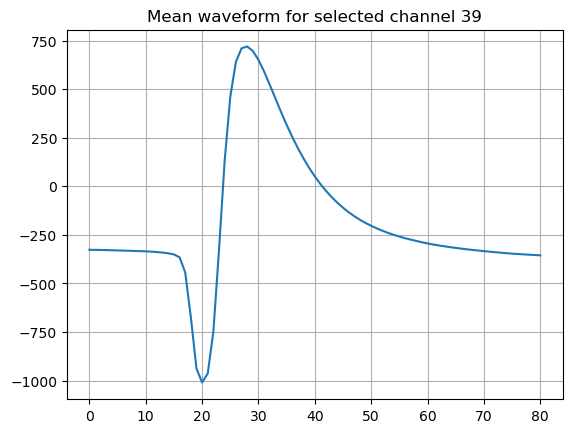

In [ ]:
import matplotlib.pyplot as plt

# Get channel index in the output array (not global index)
channel_i = 0  # if it's the first in selected_channels
mean_waveform = snippets[:, channel_i, :].mean(axis=0)

plt.plot(mean_waveform)
plt.title(f"Mean waveform for selected channel {selected_channels[channel_i]}")
plt.grid(True)
plt.show()


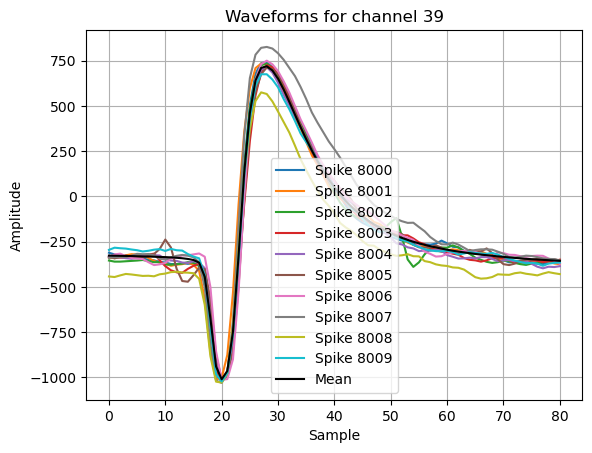

In [ ]:
import matplotlib.pyplot as plt

# Get channel index in the output array (not global index)
channel_i = 0  # if it's the first in selected_channels

for i in range(8000,8010):
    plt.plot(snippets[i, channel_i, :], label=f"Spike {i}")

plt.plot(mean_waveform, color="black", label="Mean")
plt.title(f"Waveforms for channel {selected_channels[channel_i]}")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
print(selected_channels)

[ 39  43  35  91 171 166 110 118  31 159 102 172  79  99 170 165 167  55
 168  38 169 122 126  71 164  83 158 177  27 179  94  54 173  30 107  87
  50  34 125  63 115 157 114 163 106 180  95  59 174 162 151  51  86 156
 123  58 178 184  23  26  98 160 117 161 103  22  75  40 185  19 143 150
  62 182  53  37 186  90 155 109 111  29 119 121  78 175 154  82 101 187
 142 149 181 183 192  61  66  18  93 153  15  49]


[1962 2078 2366 2468 2719]


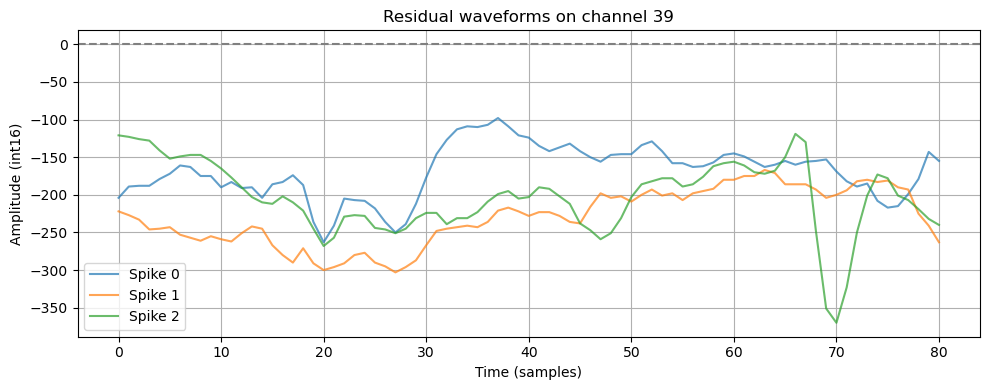

int16


In [ ]:
import matplotlib.pyplot as plt

# --- Choose the channel and spikes to visualize ---
channel_to_plot = 39
spike_indices = [0, 1, 2]  # Replace with desired spike indices

# --- Extract residuals ---
residuals = all_residual_snips[channel_to_plot]  # shape: (n_spikes, snip_len)

print(all_write_locs[channel_to_plot])

# --- Plot ---
plt.figure(figsize=(10, 4))
for i in spike_indices:
    plt.plot(residuals[i], alpha=0.7, label=f"Spike {i}")
plt.axhline(0, linestyle='--', color='gray')
plt.title(f"Residual waveforms on channel {channel_to_plot}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (int16)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(residuals.dtype)




In [ ]:
all_write_locs = spikes + window[0]
print(all_write_locs)

[    1962     2078     2366 ... 35985138 35989662 35996951]


In [ ]:
import axolotl_unit_loop_utils
import importlib
importlib.reload(axolotl_unit_loop_utils)

    # Step 12: edit raw data
write_locs = spikes + window[0]
if 1:
    axolotl_unit_loop_utils.apply_residuals_to_channel_major(
        dat_path_chmajor=dat_path_chmajor,
        residual_snips_per_channel=residuals_per_channel,
        write_locs=write_locs,
        selected_channels=selected_channels,
        total_samples=total_samples,
        dtype=dtype,
        n_channels=n_channels
    )

    with open(dat_path_chmajor, 'rb') as f:
        offset = (39 * total_samples + write_locs[0]) * np.dtype(np.int16).itemsize
        f.seek(offset)
        post_edit_snip = np.fromfile(f, dtype=np.int16, count=81)

    plt.plot(post_edit_snip)
    plt.title("Post-subtraction, from disk")
    plt.grid(True)
    plt.show()


    #end_time = time.time()
    #elapsed = end_time - start_time
    #print(f"Processed unit {unit_id} with {len(spikes)} spikes in {elapsed:.1f} seconds.")

    # # Step 12: Repeat until done
    # unit_id += 1
    # if unit_id >= max_units:
    #     print("Reached unit limit.")
    #     break


NameError: name 'write_locs' is not defined

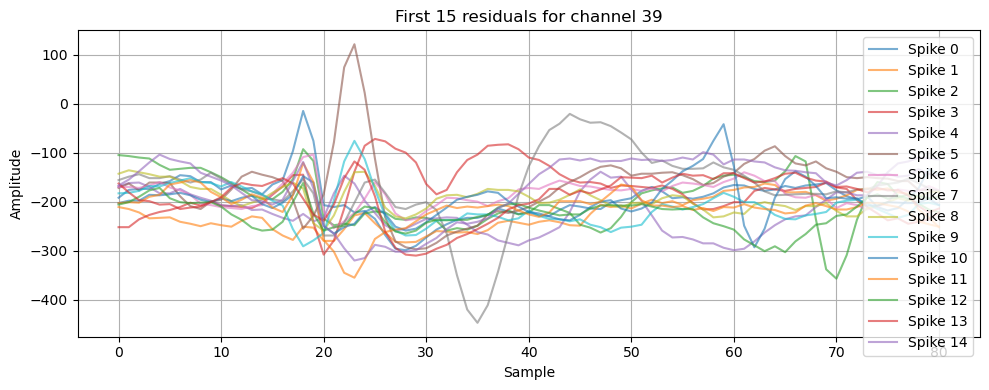

In [ ]:
channel = 39
n_to_plot = 15

# Extract the residuals for this channel
residuals = residuals_per_channel[channel]

# Plot the first few
plt.figure(figsize=(10, 4))
for i in range(min(n_to_plot, residuals.shape[0])):
    plt.plot(residuals[i], label=f"Spike {i}", alpha=0.6)

plt.title(f"First {n_to_plot} residuals for channel {channel}")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


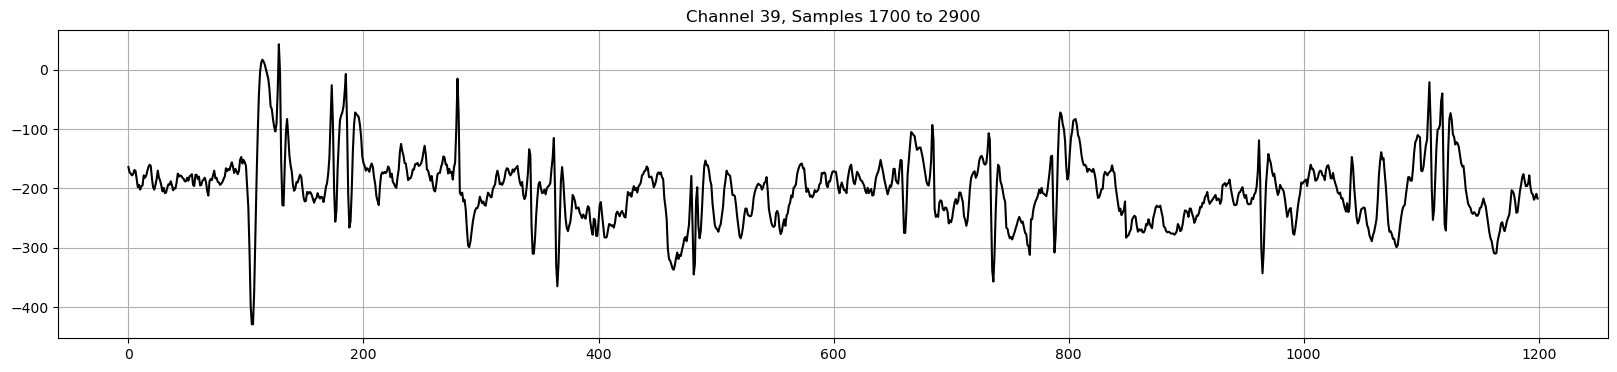

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

# --- Parameters ---
dat_path_chmajor = '/Volumes/Lab/Users/alexth/axolotl/201703151_data001_chmajor.dat'
dtype = np.int16
n_channels = 512
channel_index = 39          # Channel to extract
start_sample = 1700            # Start time index (in samples)
n_samples = 1200            # Number of time samples to read

# --- Determine total timepoints ---
file_size_bytes = np.memmap(dat_path_chmajor, dtype=dtype, mode='r').nbytes
bytes_per_sample = np.dtype(dtype).itemsize
total_samples = file_size_bytes // bytes_per_sample
total_timepoints = total_samples // n_channels

# --- Memory map full file with known shape ---
data = np.memmap(dat_path_chmajor, dtype=dtype, mode='r', shape=(n_channels, total_timepoints))

# --- Extract desired trace ---
trace = data[channel_index, start_sample:start_sample + n_samples]

# --- (Optional) Plot ---
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.plot(trace, color='black')
plt.title(f"Channel {channel_index}, Samples {start_sample} to {start_sample + n_samples}")
plt.grid(True)
